In [1]:
library(mice)
library(finalfit)
library(ggplot2)
library(dplyr)
library(stats)
library(miceadds)
library(missMethods)
library(smotefamily)
library(caret)
library(cowplot)
library(mlr)
library(fastDummies)
library(DMwR2)
library(mlmi)
library(ranger)
library(scales)

Warning message:
"pakiet 'mice' został zbudowany w wersji R 4.3.2"

Dołączanie pakietu: 'mice'


Następujący obiekt został zakryty z 'package:stats':

    filter


Następujące obiekty zostały zakryte z 'package:base':

    cbind, rbind


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


* miceadds 3.16-18 (2023-01-06 10:54:00)

Ładowanie wymaganego pakietu: lattice

Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.3.2"
Warning message:
"pakiet 'mlr' został zbudowany w wersji R 4.3.2"
Ładowanie wymaganego pakietu: ParamHelpers

Warning message:
"pakiet 'ParamHelpers' został zbudowany w wersji R 4.3.2"
Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to t

In [2]:
visImpCont <- function(orig_data, imp_data, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variabl.

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [3]:
visImpCat <- function(orig_data, imp_data, miss_var, imp_type) {
    #' Visualize imputation of missing data for categorical variable.

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [4]:
visImpMul <- function(orig_data, imp_data, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable (multiple imputation).

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p <- ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [5]:
visImpMulCat <- function(orig_data, imp_data, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable (multiple imputation).

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p<- ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [6]:
create_zero_df <- function(num_rows, num_cols, colnames) {
  #' Create dataframe of zeros.
  
  df <- as.data.frame(matrix(0, nrow = num_rows, ncol = num_cols))
  names(df) <- colnames
  return(df)
}

In [1]:
newblots <- function(old_blots, param_list){
    #' Create new blots for narfcs imputation.
    
    new_blots <- old_blots
    for (i in names(new_blots)) {
        par <- param_list[[i]]
        ums <- new_blots[[i]][["ums"]]
        for (j in 1:length(par)){
            ind <- regexpr("\\$", ums)[1]
            if (par[[j]] >= 0){
                part1 <- substr(ums, 1, ind-1)
                part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
            }
            else{
                part1 <- substr(ums, 1, ind-2)
                part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
            }
            ums <- paste0(part1, as.character(par[[j]]), part2)
            new_blots[[i]][["ums"]] <- ums
            }
    }
    new_blots
}

In [170]:
CSPalg2 <- function(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat){
    #' Algorithm 2 for finding CSPs.
    
    MSP <- as.list(NULL)
    range <- as.list(NULL)

    for (i in 1:length(l)){
    range[[i]] <- vector("list", length(l[[i]]))
        for (j in 1:length(l[[i]])){
            range[[i]][[j]] <- seq(l[[i]][[j]], u[[i]][[j]], step[[i]][[j]])
        }
    }

    range2 <- list()
    counter <- 0
    for (i in 1:length(range)){
        for (j in 1:length(range[[i]])){
            counter <- counter + 1
            range2[[counter]] <- range[[i]][[j]]
        }
    }
    
    points <- expand.grid(range2)

    for(j in 1:nrow(points)){
        parmsnew <- relist(as.matrix(points[j,]), parms)
        for (k in 1:length(parmsnew)){
            for (l in 1:length(i)) {
                parmsnew[[k]][[l]] <- round(parmsnew[[k]][[l]], 4)
            }
        }
        imp_blots <- newblots(base_blots, parmsnew)
        set.seed(seed)
        narfcs <- mice(data=data, m=m, maxit=maxit, method=method, blots=imp_blots, print=FALSE, predictorMatrix=predmat)
        MSPlist <- c()
        for(n in 1:length(MSPmodels)){
            MSPlm <- with(data=narfcs, exp=glm(formula=as.formula(MSPmodels[n]), family=MSPfamily[n]))
            pooled <- summary(pool(MSPlm))$estimate
            estim <- pooled[2:length(pooled)]
            MSPlist <- c(MSPlist, estim)
            }
        MSP[[j]] <- MSPlist
    }
    
    dif <- as.vector(NULL)
    for(p in 1:nrow(points)){
        dif[[p]] <- tol-abs(MSP[[p]]-elicited)
    }

    Msps <- do.call(rbind, MSP)
    colnames(Msps) <- rep("c",ncol(Msps))
    for(i in 1:ncol(Msps)){ 
        colnames(Msps)[i] <- paste("MSP", i)
    }


    colnames(points) <- rep("c", ncol(points))
    for(i in 1:ncol(points)){ 
     colnames(points)[i] <- paste("CSP", i)
    }
    Csps <- points

    con <- lapply(dif, function(x) all(x>0))
    MSPcal <- MSP[c(which(con==TRUE))]
    CSPcal <- as.data.frame(points[c(which(con==TRUE)),])

    if (nrow(CSPcal) == 0){
        return(list(calibratedMSP=NA, calibratedCSP=NA, Csps=Csps, Msps=Msps))
    }

    else{
        calibratedMSP <- do.call(rbind, MSPcal)
        colnames(calibratedMSP) <- rep("c",ncol(calibratedMSP))
        for(i in 1:ncol(calibratedMSP)){ 
            colnames(calibratedMSP)[i] <- paste("MSP", i)
        }

        colnames(CSPcal) <- rep("c",ncol(CSPcal))
        for(i in 1:ncol(CSPcal)){ 
        colnames(CSPcal)[i] <- paste("CSP",i)
        }

        return(list(calibratedMSP=calibratedMSP, calibratedCSP=CSPcal, Csps=Csps, Msps=Msps))
    }
}

In [163]:
find_CSP <- function(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat) {
    #' Run Algorithm 2 repeatedly to find CSPs.

    found <- FALSE

    while (!found) {
        calib <- CSPalg2(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat)

        if (typeof(calib$calibratedMSP) != "logical") {
            diff <- abs(calib$calibratedMSP - elicited)
            csps <- rep(0, ncol(diff))
            for (i in 1:ncol(diff)) {
                ind <- which(diff[, i] == min(diff[, i]))[1]
                csps[i] <- calib$calibratedMSP[ind, i]
            }
            found <- TRUE
        }

        else {
            diff <- abs(calib$Msps - elicited)
            for (i in 1:ncol(diff)) {
                rng_len <- (u[[i]] - l[[i]]) / step[[i]]
                step[[i]] <- 0.9 * step[[i]]
                ind <- which(diff[, i] == min(diff[, i]))[1]
                mid <- calib$Csps[ind, i]
                newl <- mid - step[[i]] * (rng_len / 2)
                newu <- mid + step[[i]] * (rng_len / 2)
                l[[i]] <- newl
                u[[i]] <- newu
            }
        }
    }

    return(csps)
}

In [10]:
create_data <- function(categorical, nrows, mechanism, beta=1, mu=0, var=1, prob=0.3, gsh=1, gsc=2) {
    #' Create synthetic data for statistical estimates task.

    if (categorical == FALSE) {
        x <- rnorm(nrows, mean=mu, sd=sqrt(var))
        y <- rgamma(nrows, shape=gsh, scale=gsc)
        z <- beta*x + rnorm(nrows)
        data <- data.frame(x=x, y=y, z=z)
    }
    else {
        x <- rbinom(nrows, 1, prob)
        y <- rgamma(nrows, shape=gsh, scale=gsc)
        z <- beta*x + rnorm(nrows)
        data <- data.frame(x=factor(x), y=y, z=z)        
    }

    if (mechanism == "MCAR") {
        miss_data <- delete_MCAR(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(1), n_mis_stochastic=FALSE)
        miss_data$index <- as.numeric(row.names(miss_data))
        return(list(md=miss_data, dt=NULL))
    }

    else if (mechanism == "MAR") {
       miss_data <- delete_MAR_censoring(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(1), cols_ctrl=c(2))
       miss_data$index <- as.numeric(row.names(miss_data))
       return(list(md=miss_data, dt=NULL))
    }

    else {
        miss_data <- delete_MNAR_censoring(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(1))
        
        if (categorical == FALSE) {
            x_obs <- mean(data[!is.na(miss_data$x),]$x)
            x_miss <- mean(data[is.na(miss_data$x),]$x)
            x_delta <- x_miss - x_obs
            
        }

        else {
            x_mi <- as.factor(ifelse(is.na(miss_data$x), "Missing", "Observed"))
            x_tab <- table(data.frame(miss = x_mi, x = data$x))
            x_miss <- x_tab["Missing", "1"] / x_tab["Missing", "0"]
            x_obs <- x_tab["Observed", "1"] / x_tab["Observed", "0"]
            x_delta <- x_miss - x_obs
        }

        miss_data$index <- as.numeric(row.names(miss_data))
        return(list(md=miss_data, dt=x_delta))
    } 
}

In [95]:
num1 <- create_data(FALSE, 1000, "MCAR")$md
num2 <- create_data(FALSE, 1000, "MAR")$md
mnar_num <- create_data(FALSE, 1000, "MNAR")
num3 <- mnar_num$md
delta_num <- mnar_num$dt

cat1 <- create_data(TRUE, 1000, "MCAR")$md
cat2 <- create_data(TRUE, 1000, "MAR")$md
mnar_cat <- create_data(TRUE, 1000, "MNAR")
cat3 <- mnar_cat$md
delta_cat <- mnar_cat$dt

In [96]:
predm <- make.predictorMatrix(num1)
predm[,"index"] <- 0

In [97]:
method1 <- c("mean", "", "", "")
num1_mean <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()
num2_mean <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()

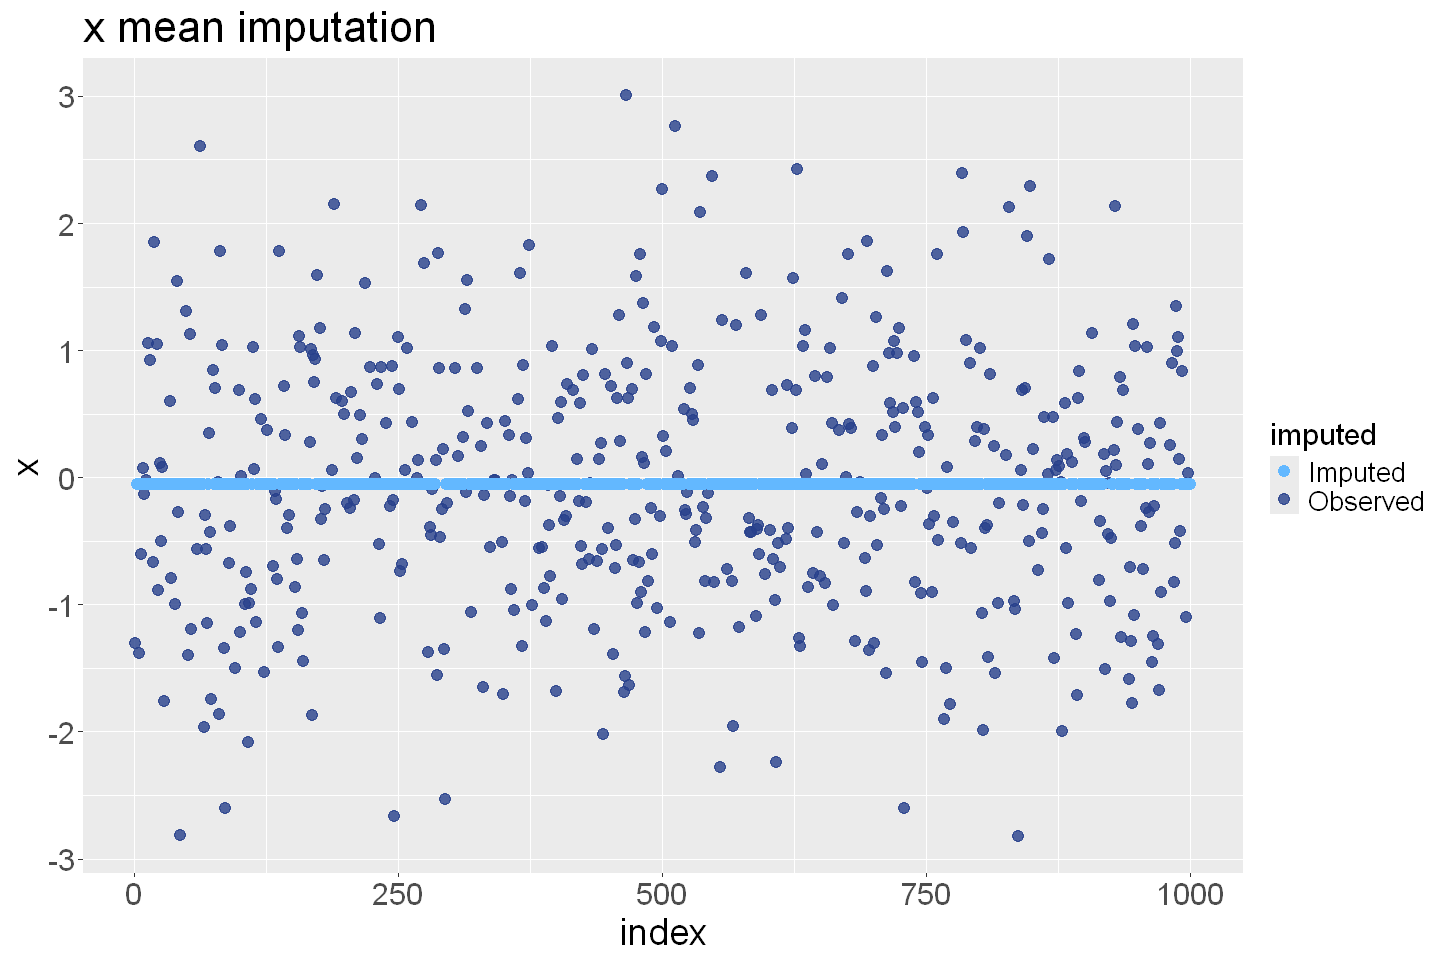

In [98]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(num1, num1_mean, "x", "mean")

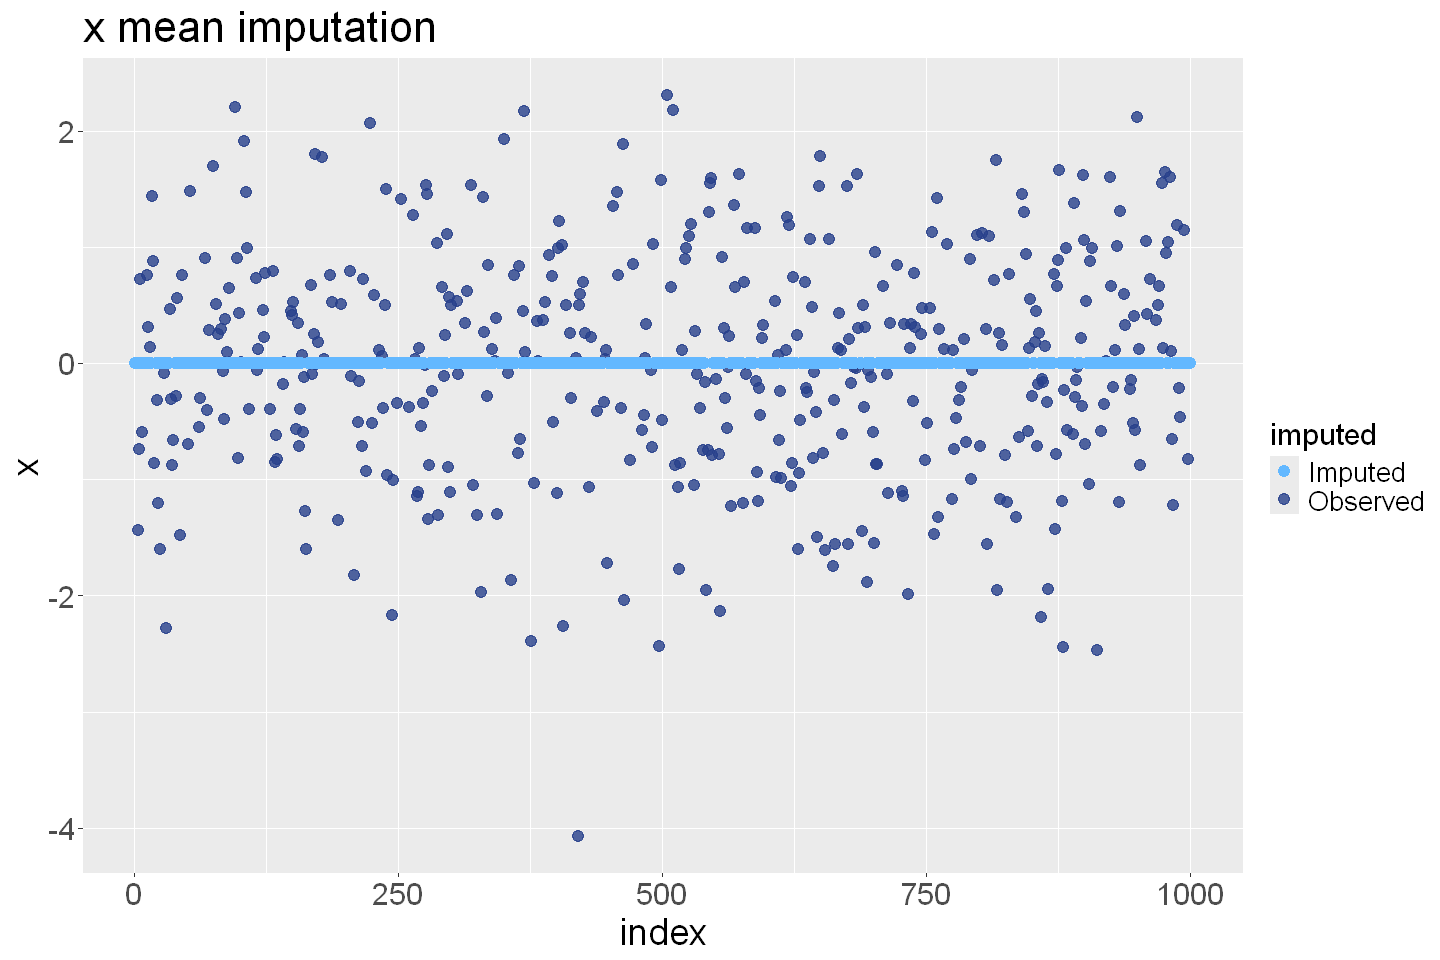

In [99]:
visImpCont(num2, num2_mean, "x", "mean")

In [100]:
method2 <- c("norm.predict", "", "", "")
num1_linreg <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()
num2_linreg <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()

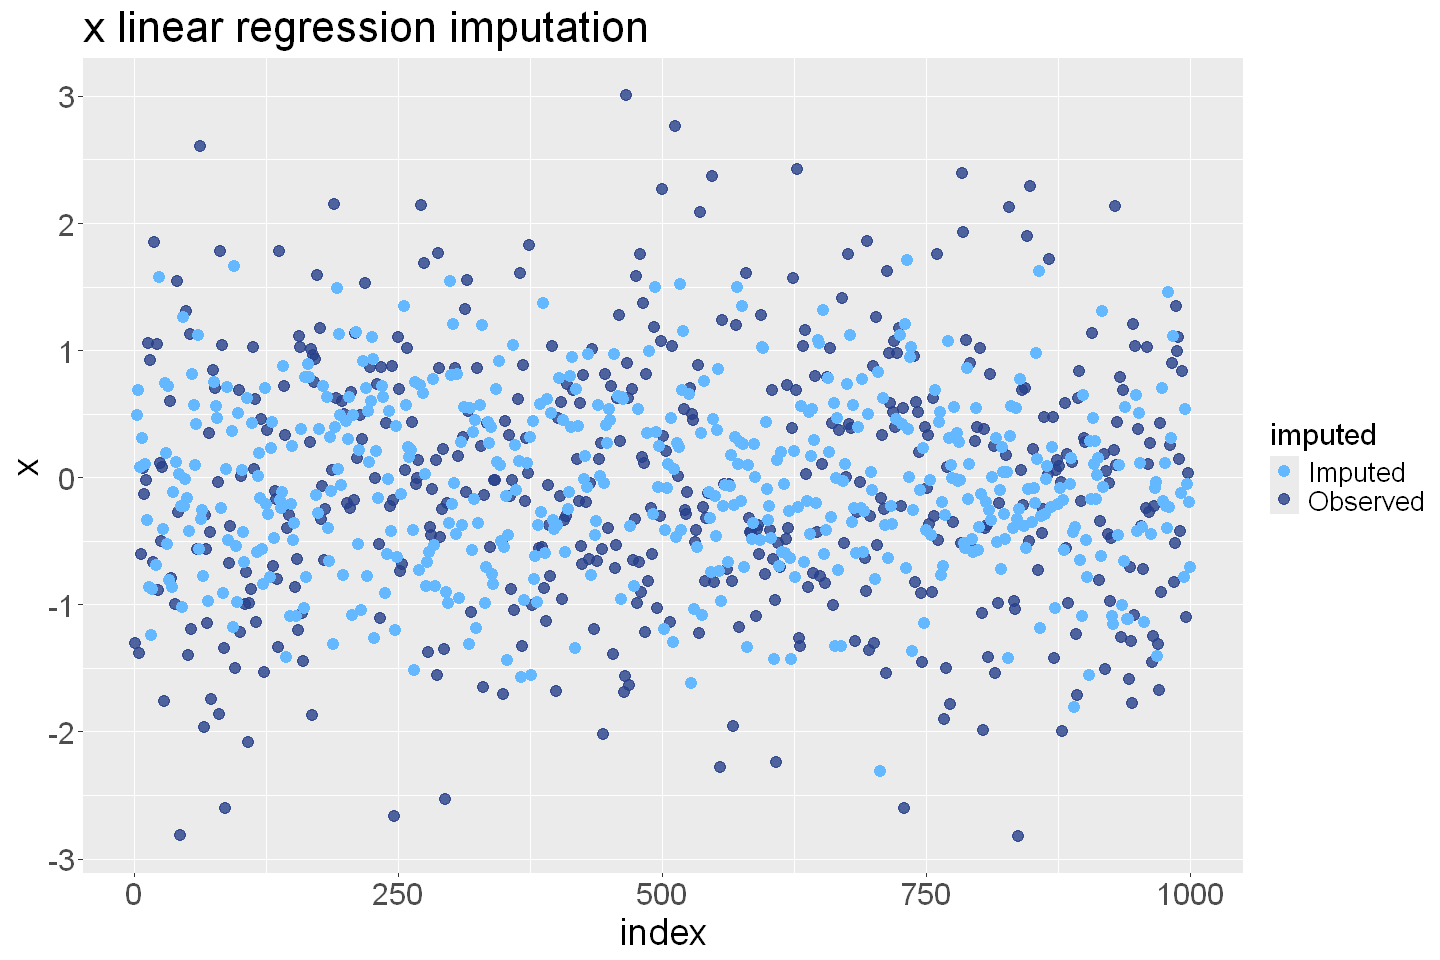

In [101]:
visImpCont(num1, num1_linreg, "x", "linear regression")

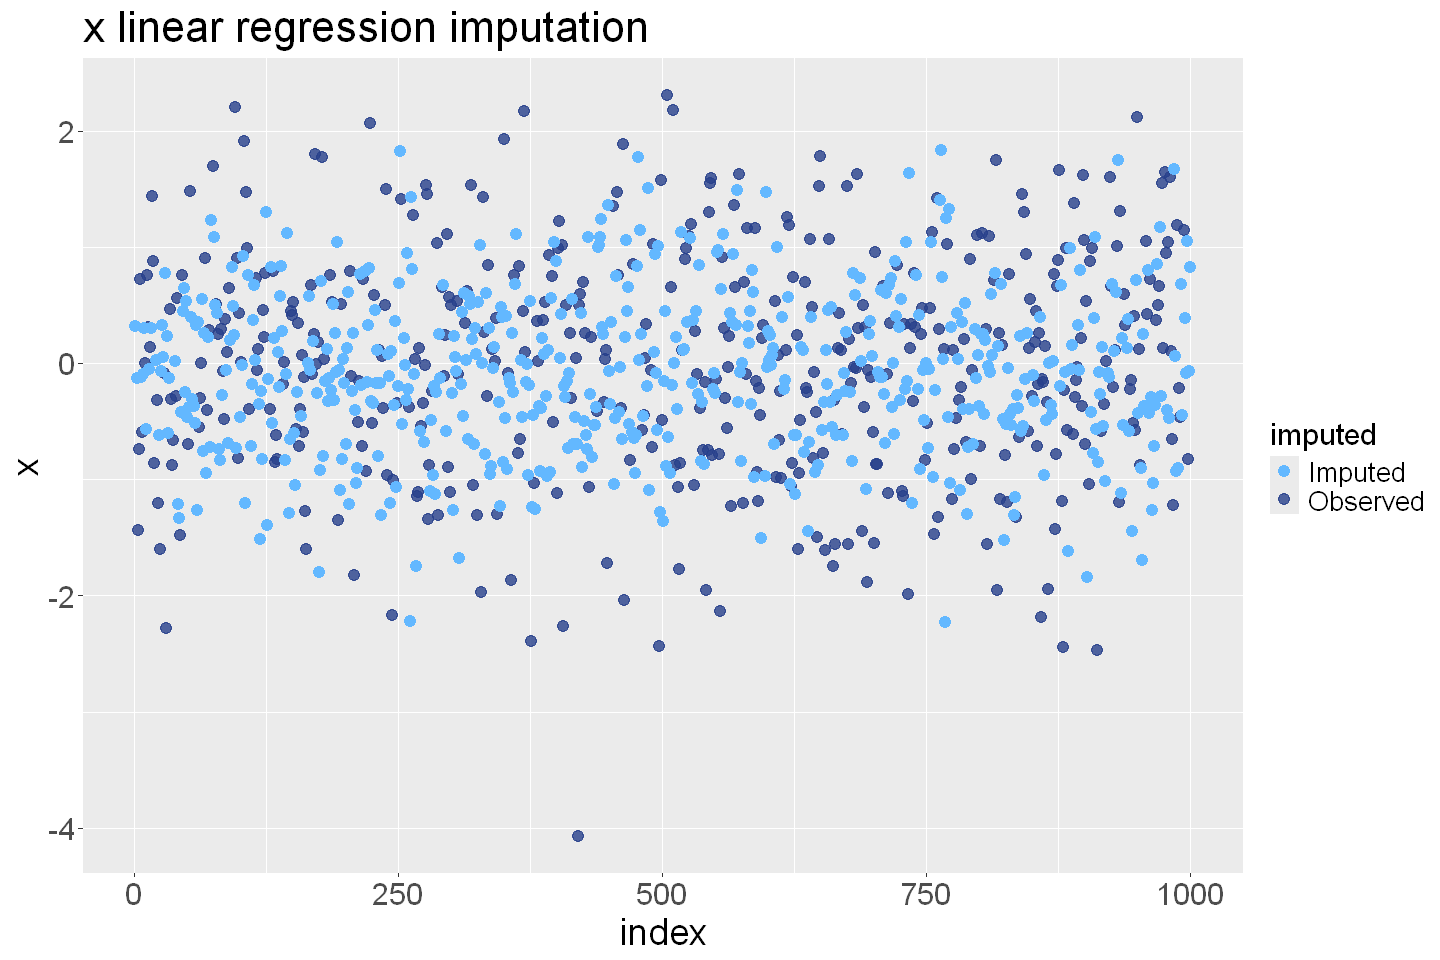

In [102]:
visImpCont(num2, num2_linreg, "x", "linear regression")

In [106]:
method3 <- c("norm.nob", "", "", "")
num1_stochreg <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()
num2_stochreg <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()

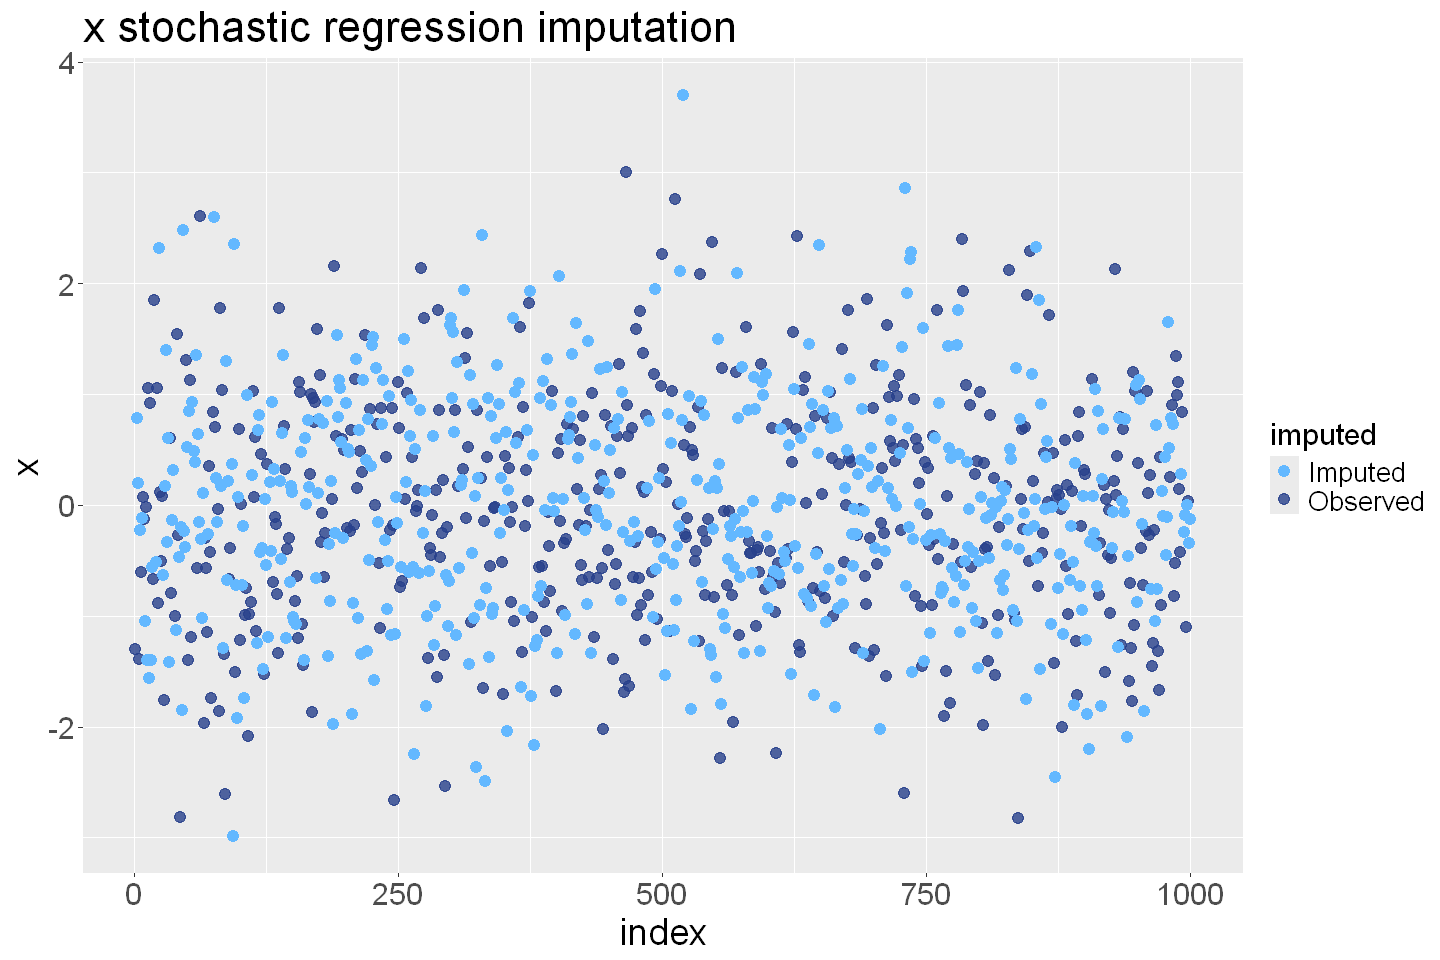

In [107]:
visImpCont(num1, num1_stochreg, "x", "stochastic regression")

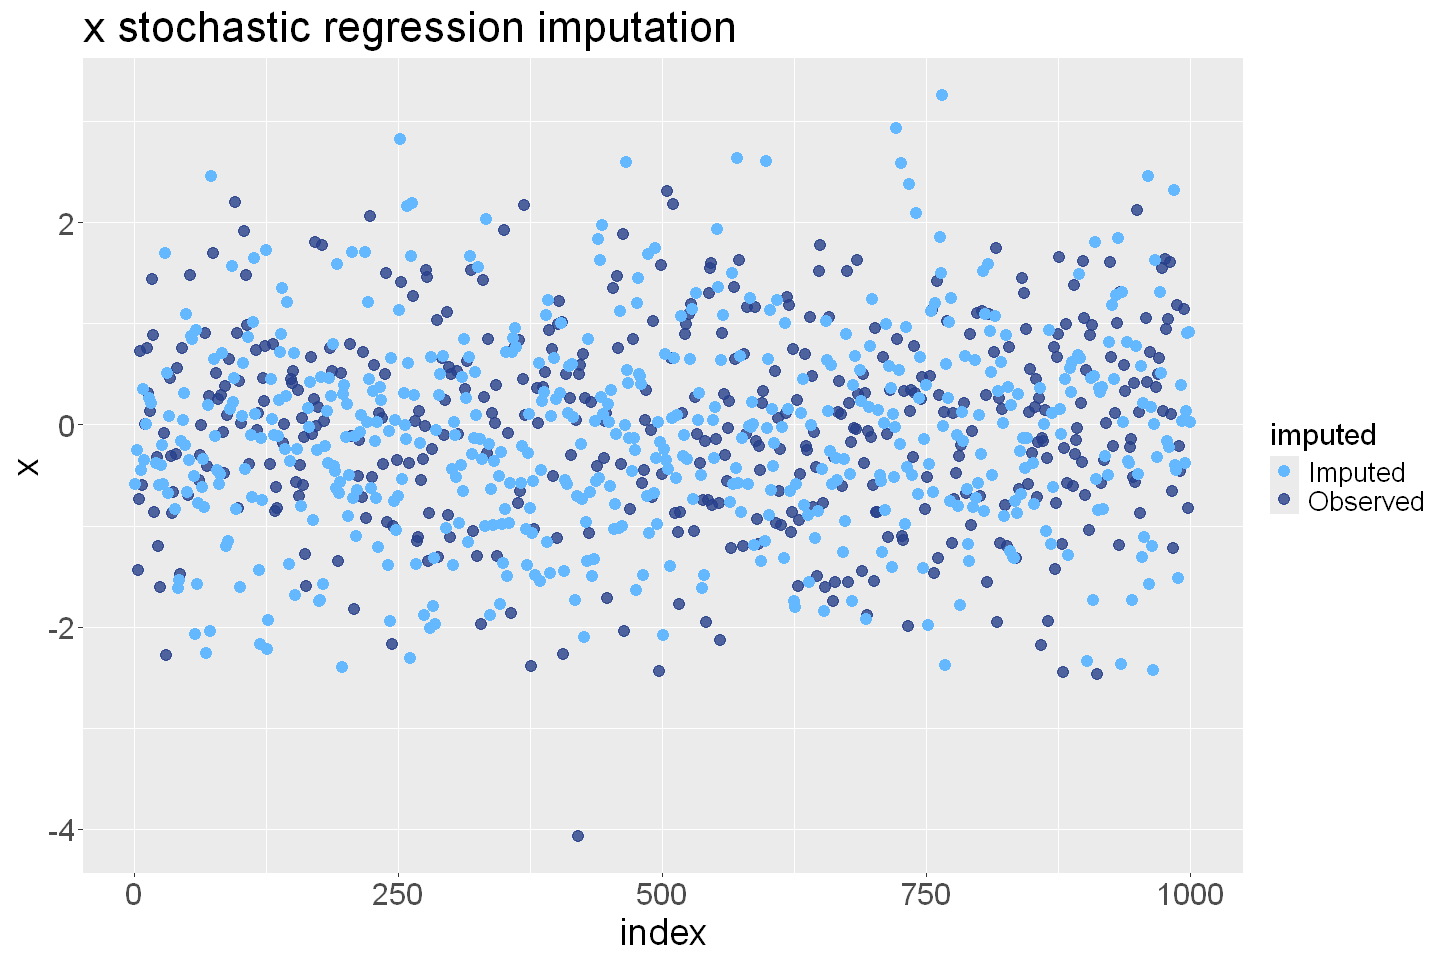

In [108]:
visImpCont(num2, num2_stochreg, "x", "stochastic regression")

In [109]:
method4 <- c("pmm", "", "", "")
num1_pmm <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()
num2_pmm <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()

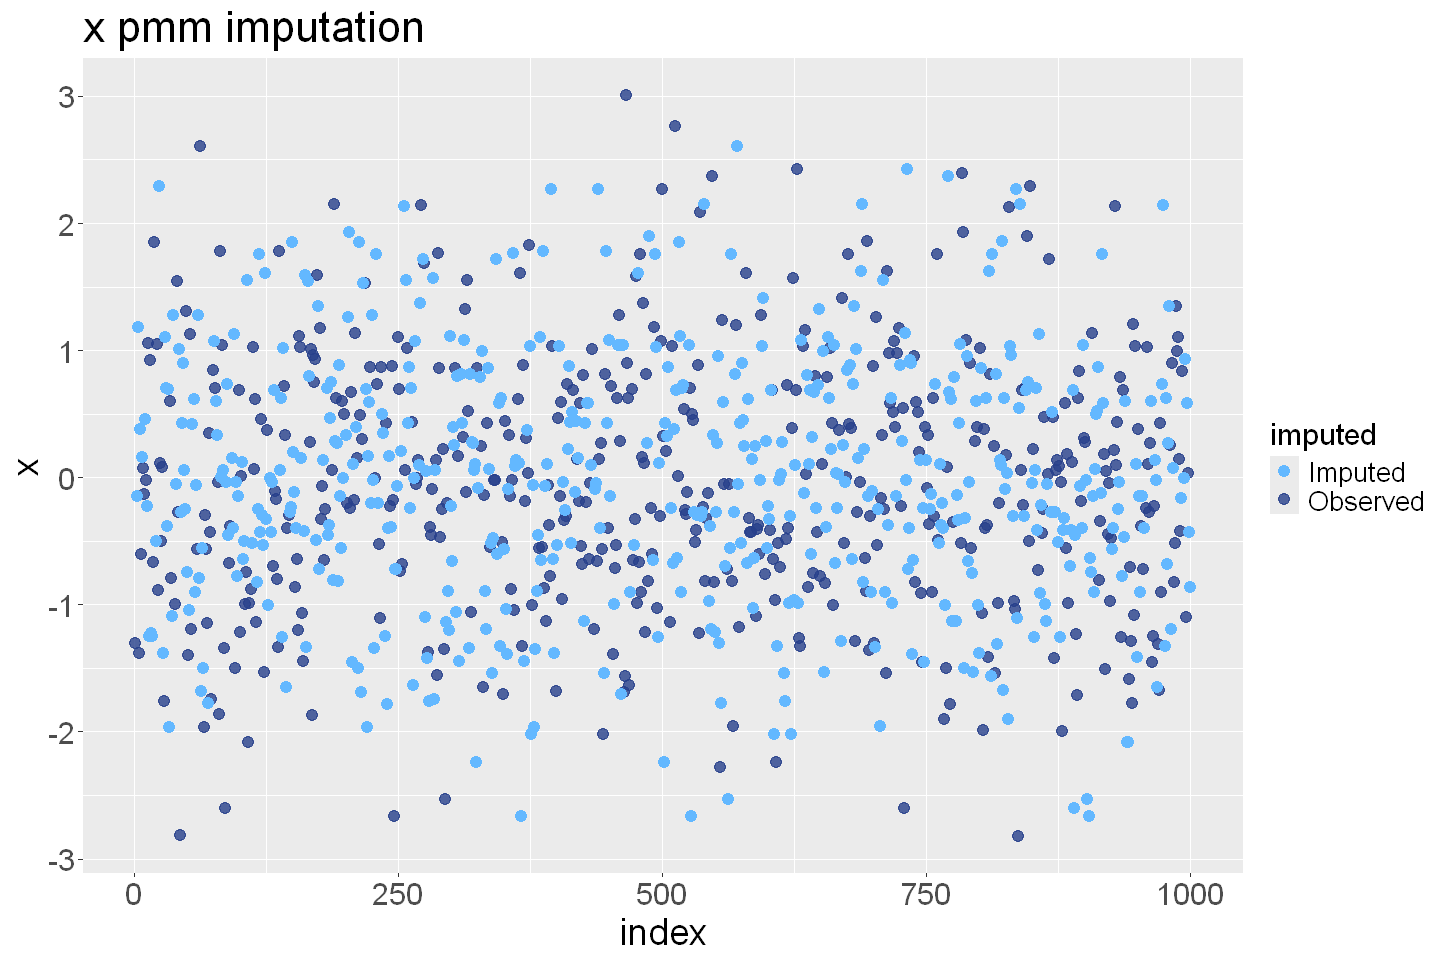

In [110]:
visImpCont(num1, num1_pmm, "x", "pmm")

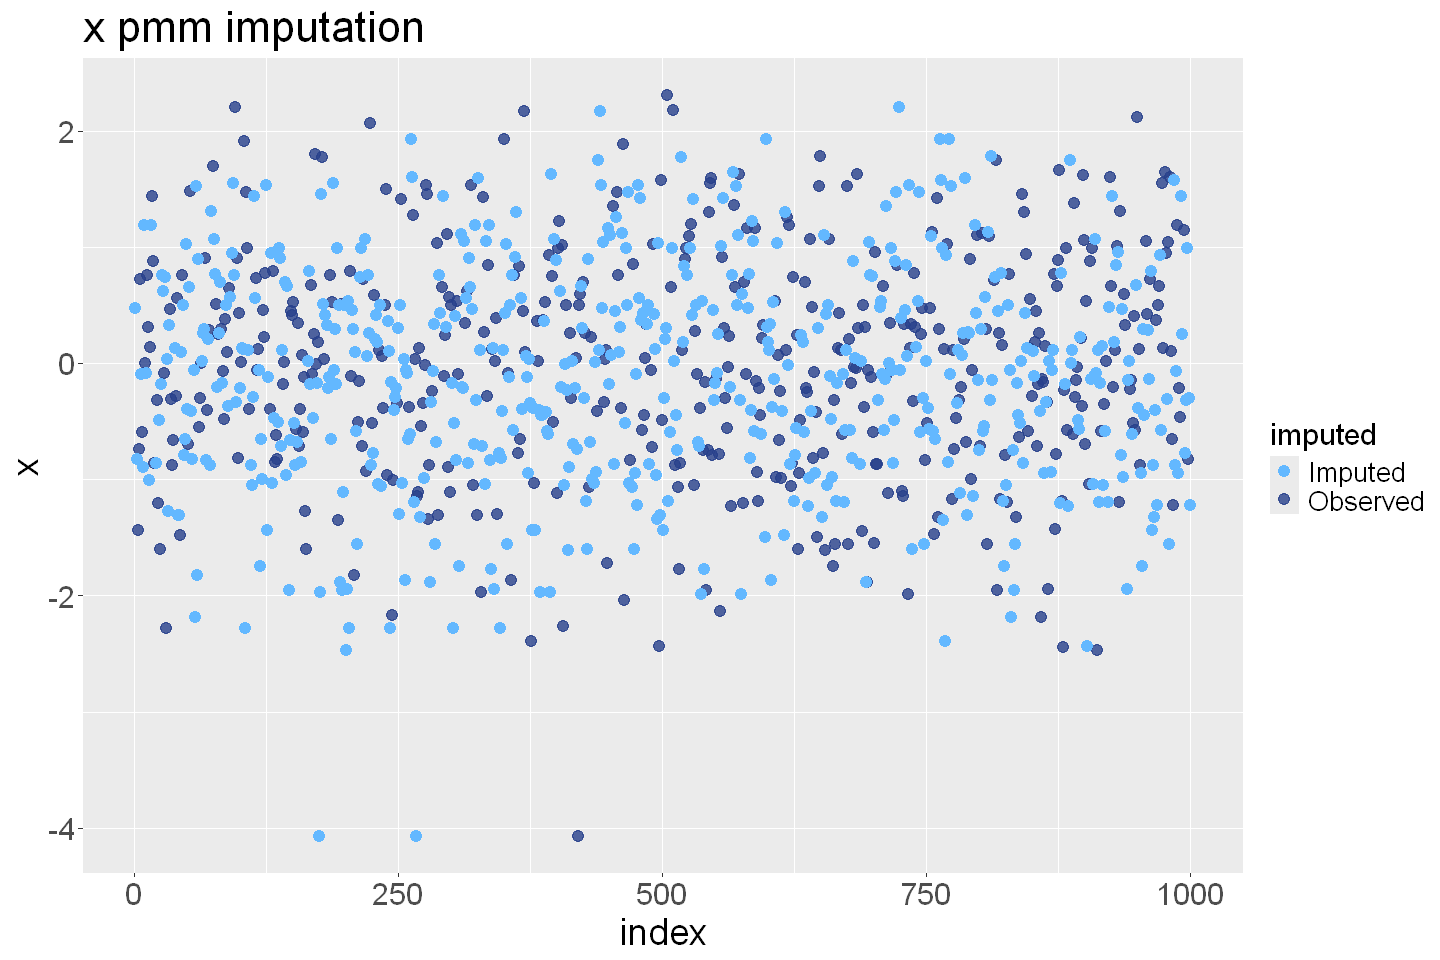

In [111]:
visImpCont(num2, num2_pmm, "x", "pmm")

In [112]:
method5 <- c("norm.predict", "", "", "")
num1_mice_linreg <- mice(data = num1, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")
num2_mice_linreg <- mice(data = num2, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")

In [113]:
num1_stack <- rbind(num1, num1, num1, num1)
num2_stack <- rbind(num2, num2, num2, num2)

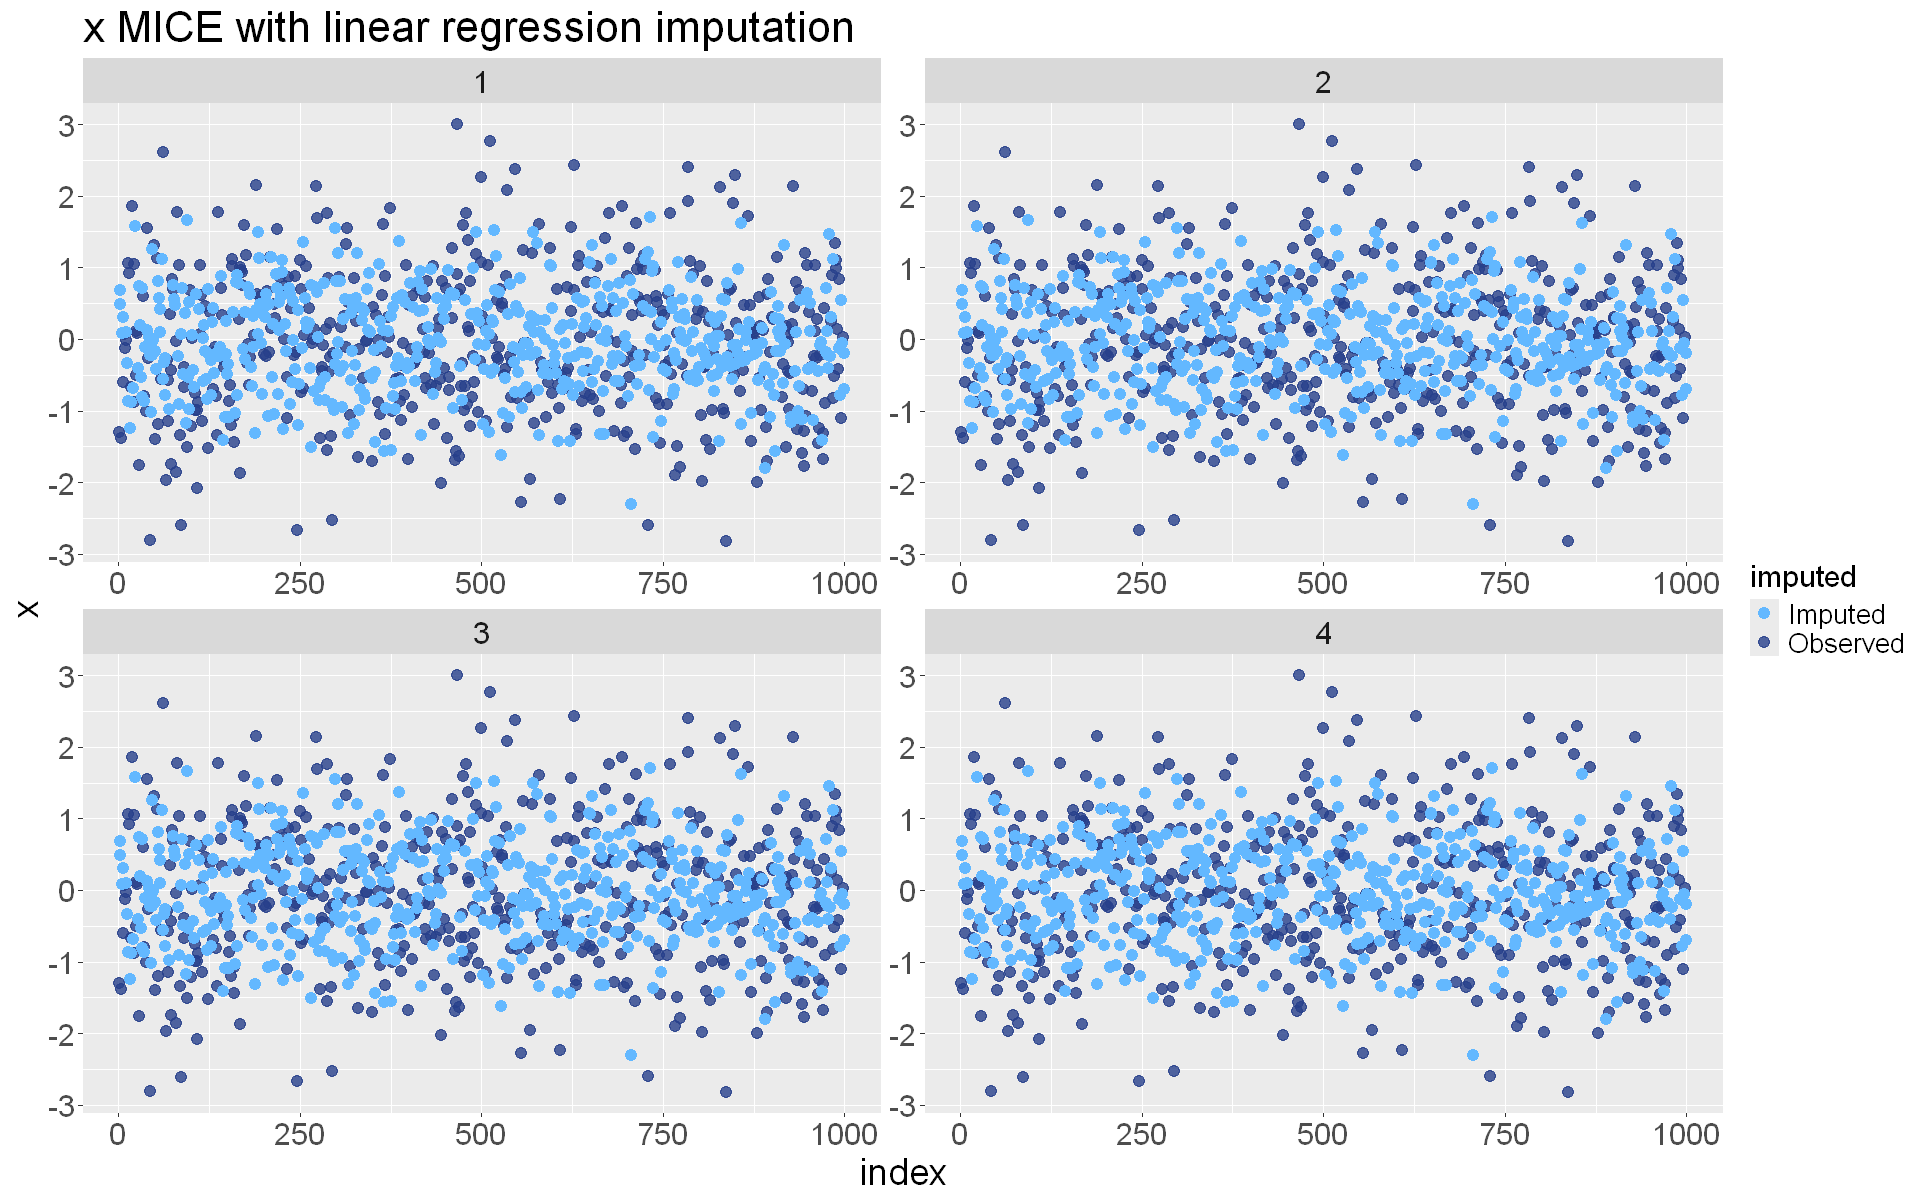

In [114]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(num1_stack, num1_mice_linreg, "x", "MICE with linear regression")

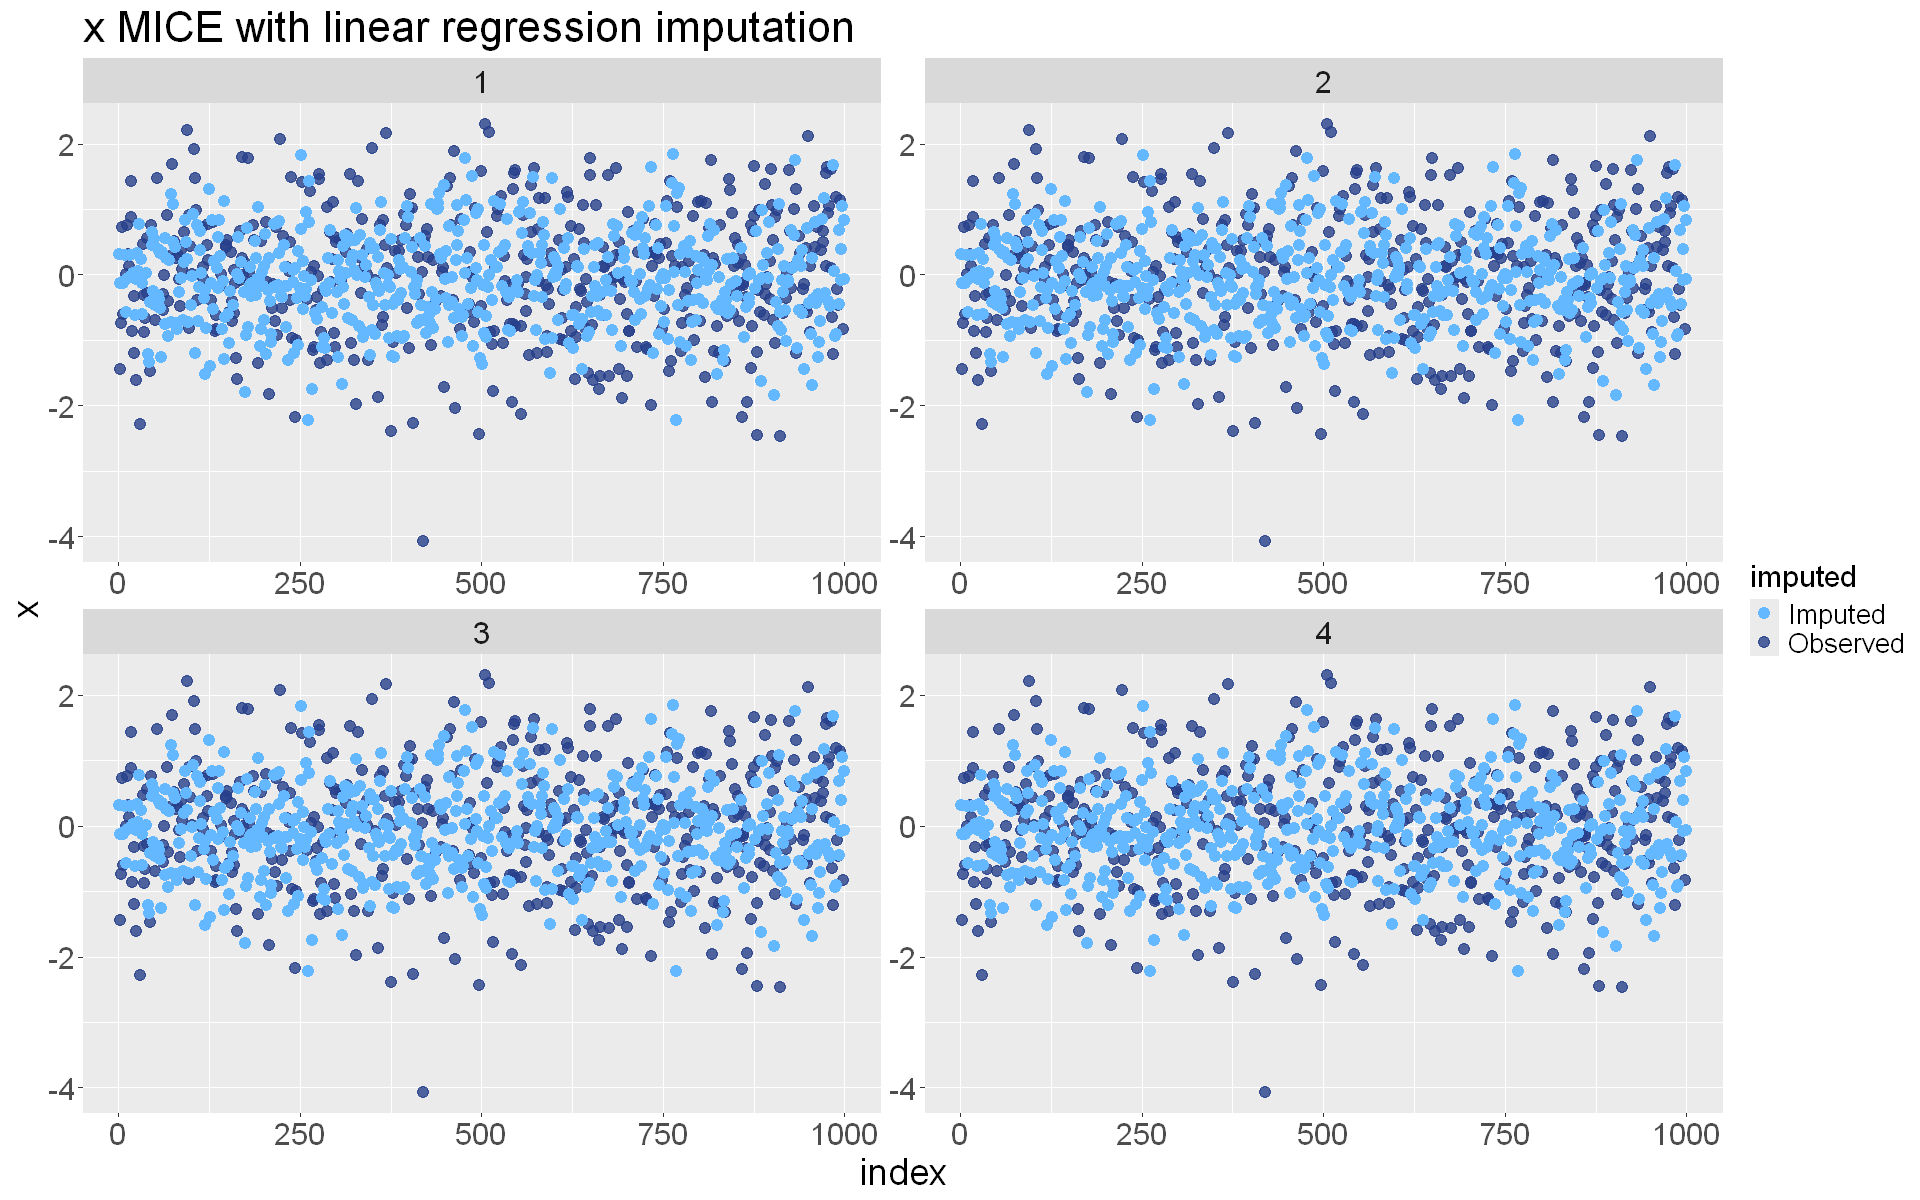

In [115]:
visImpMul(num2_stack, num2_mice_linreg, "x", "MICE with linear regression")

In [116]:
method6 <- c("norm.predict", "", "", "")
num1_mice_stochreg <- mice(data = num1, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")
num2_mice_stochreg <- mice(data = num2, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")

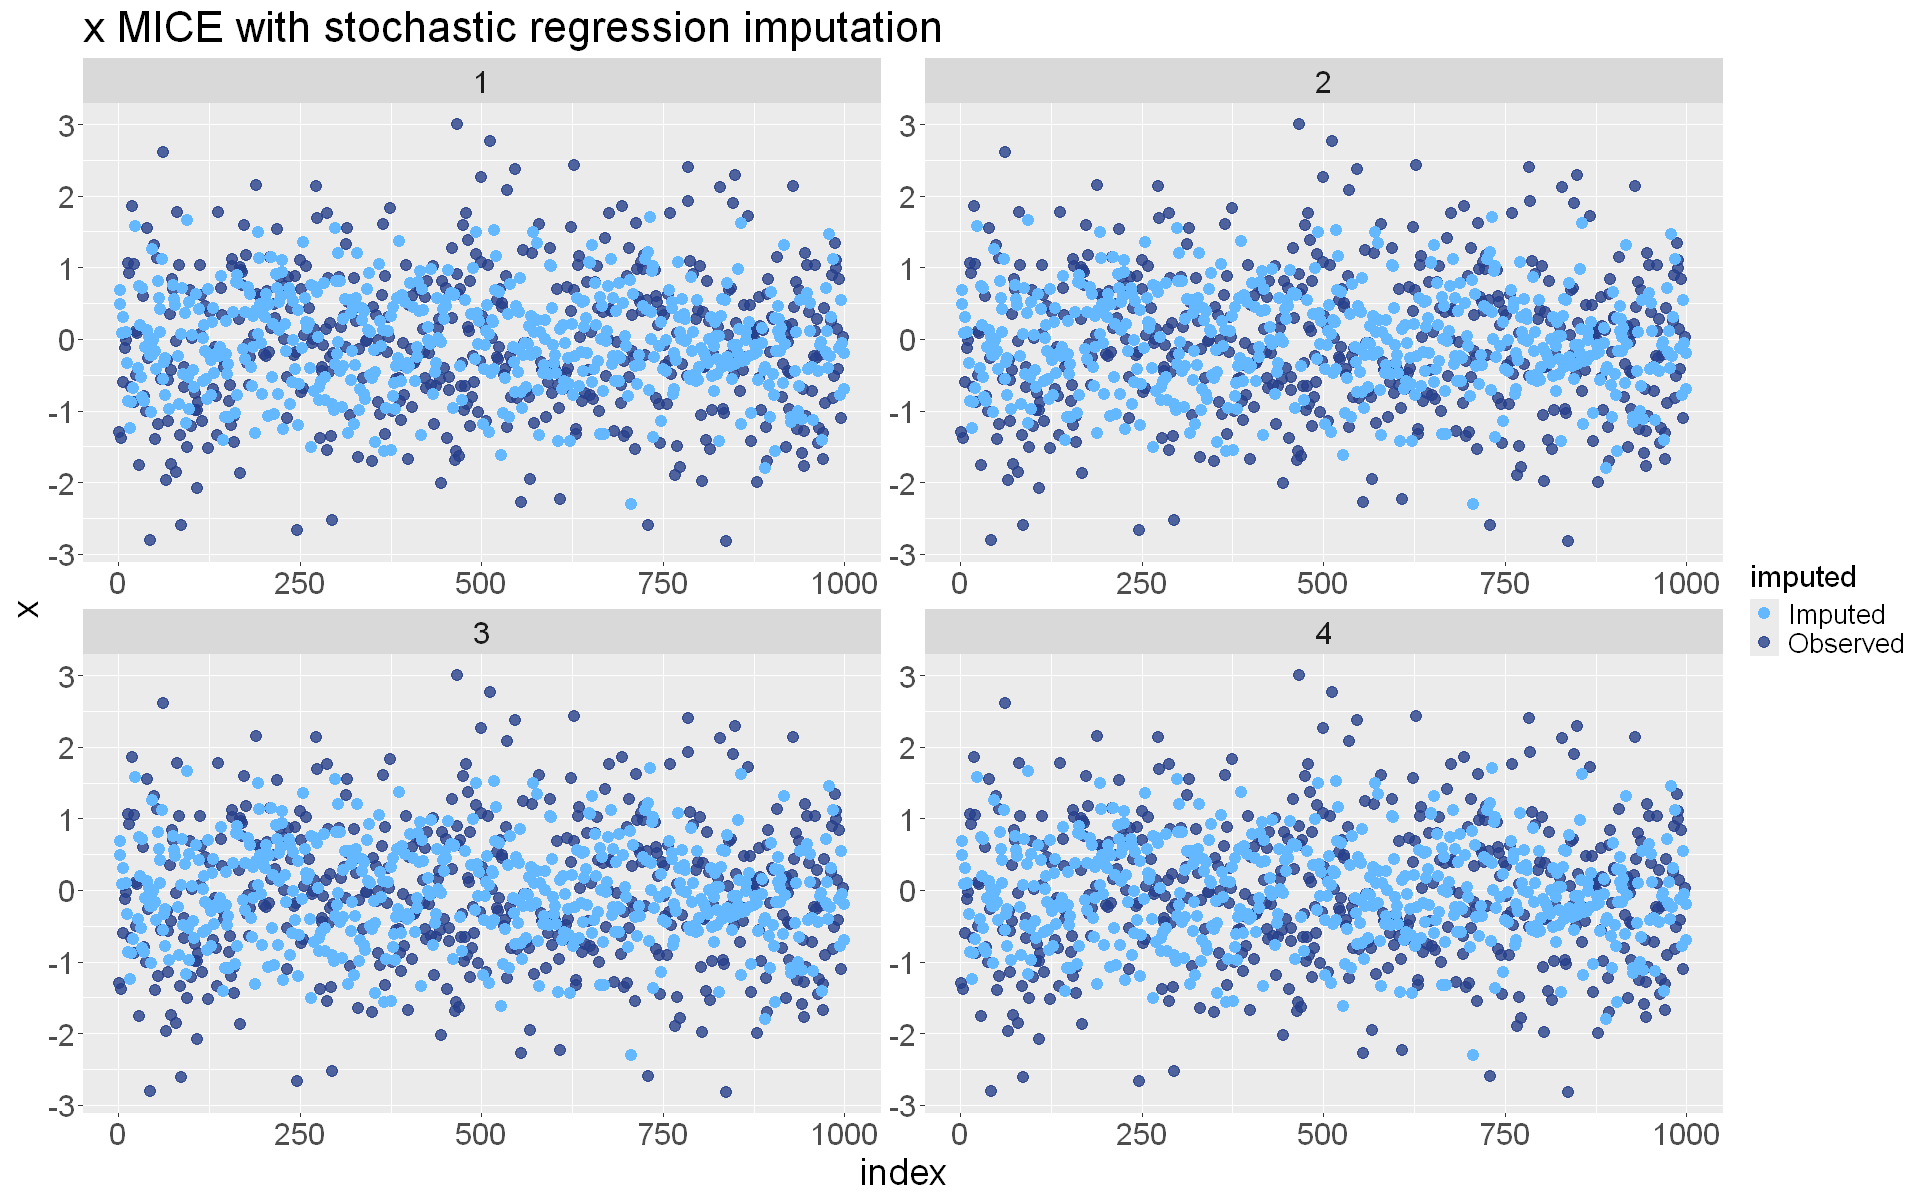

In [117]:
visImpMul(num1_stack, num1_mice_stochreg, "x", "MICE with stochastic regression")

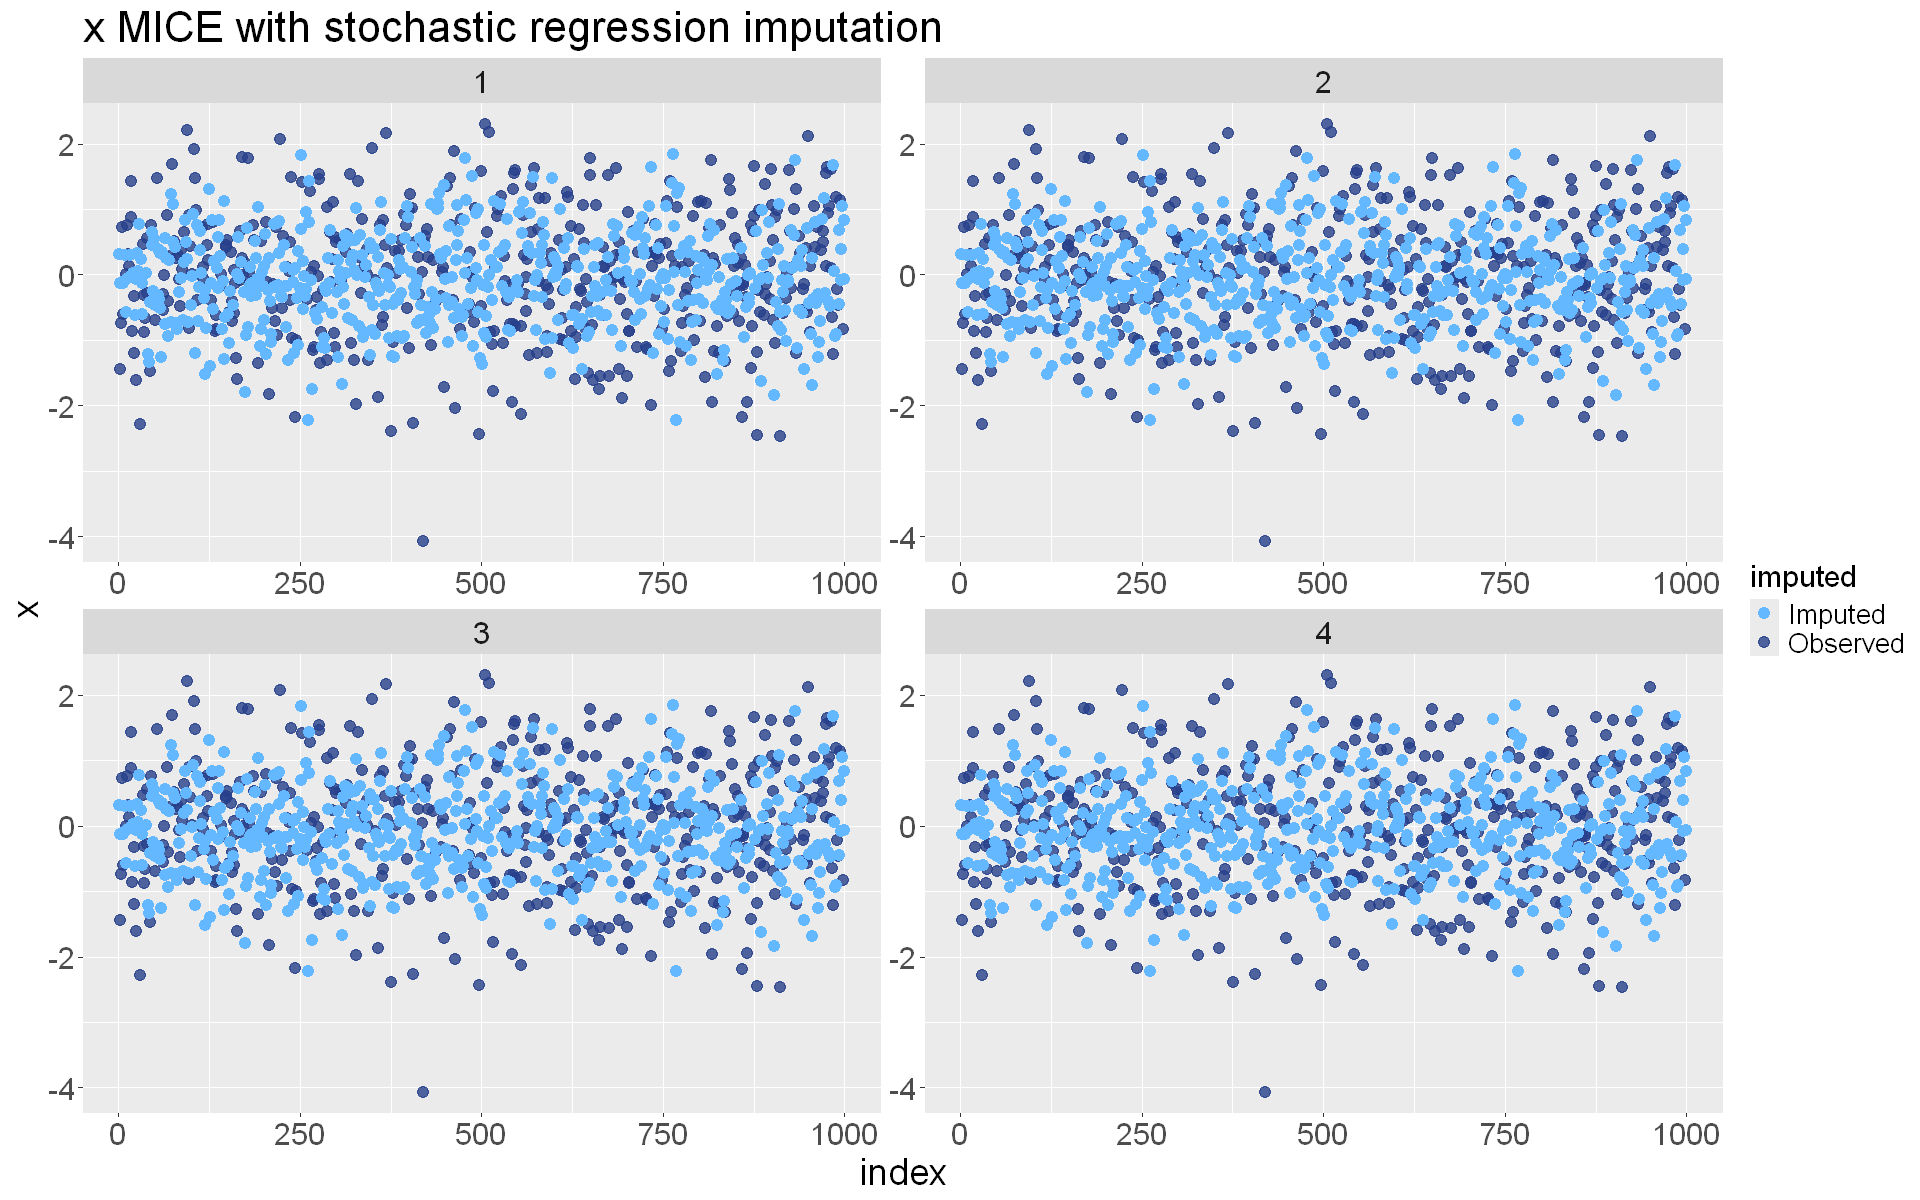

In [119]:
visImpMul(num2_stack, num2_mice_stochreg, "x", "MICE with stochastic regression")

In [120]:
method7 <- c("pmm", "", "", "")
num1_mice_pmm <- mice(data = num1, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")
num2_mice_pmm <- mice(data = num2, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")

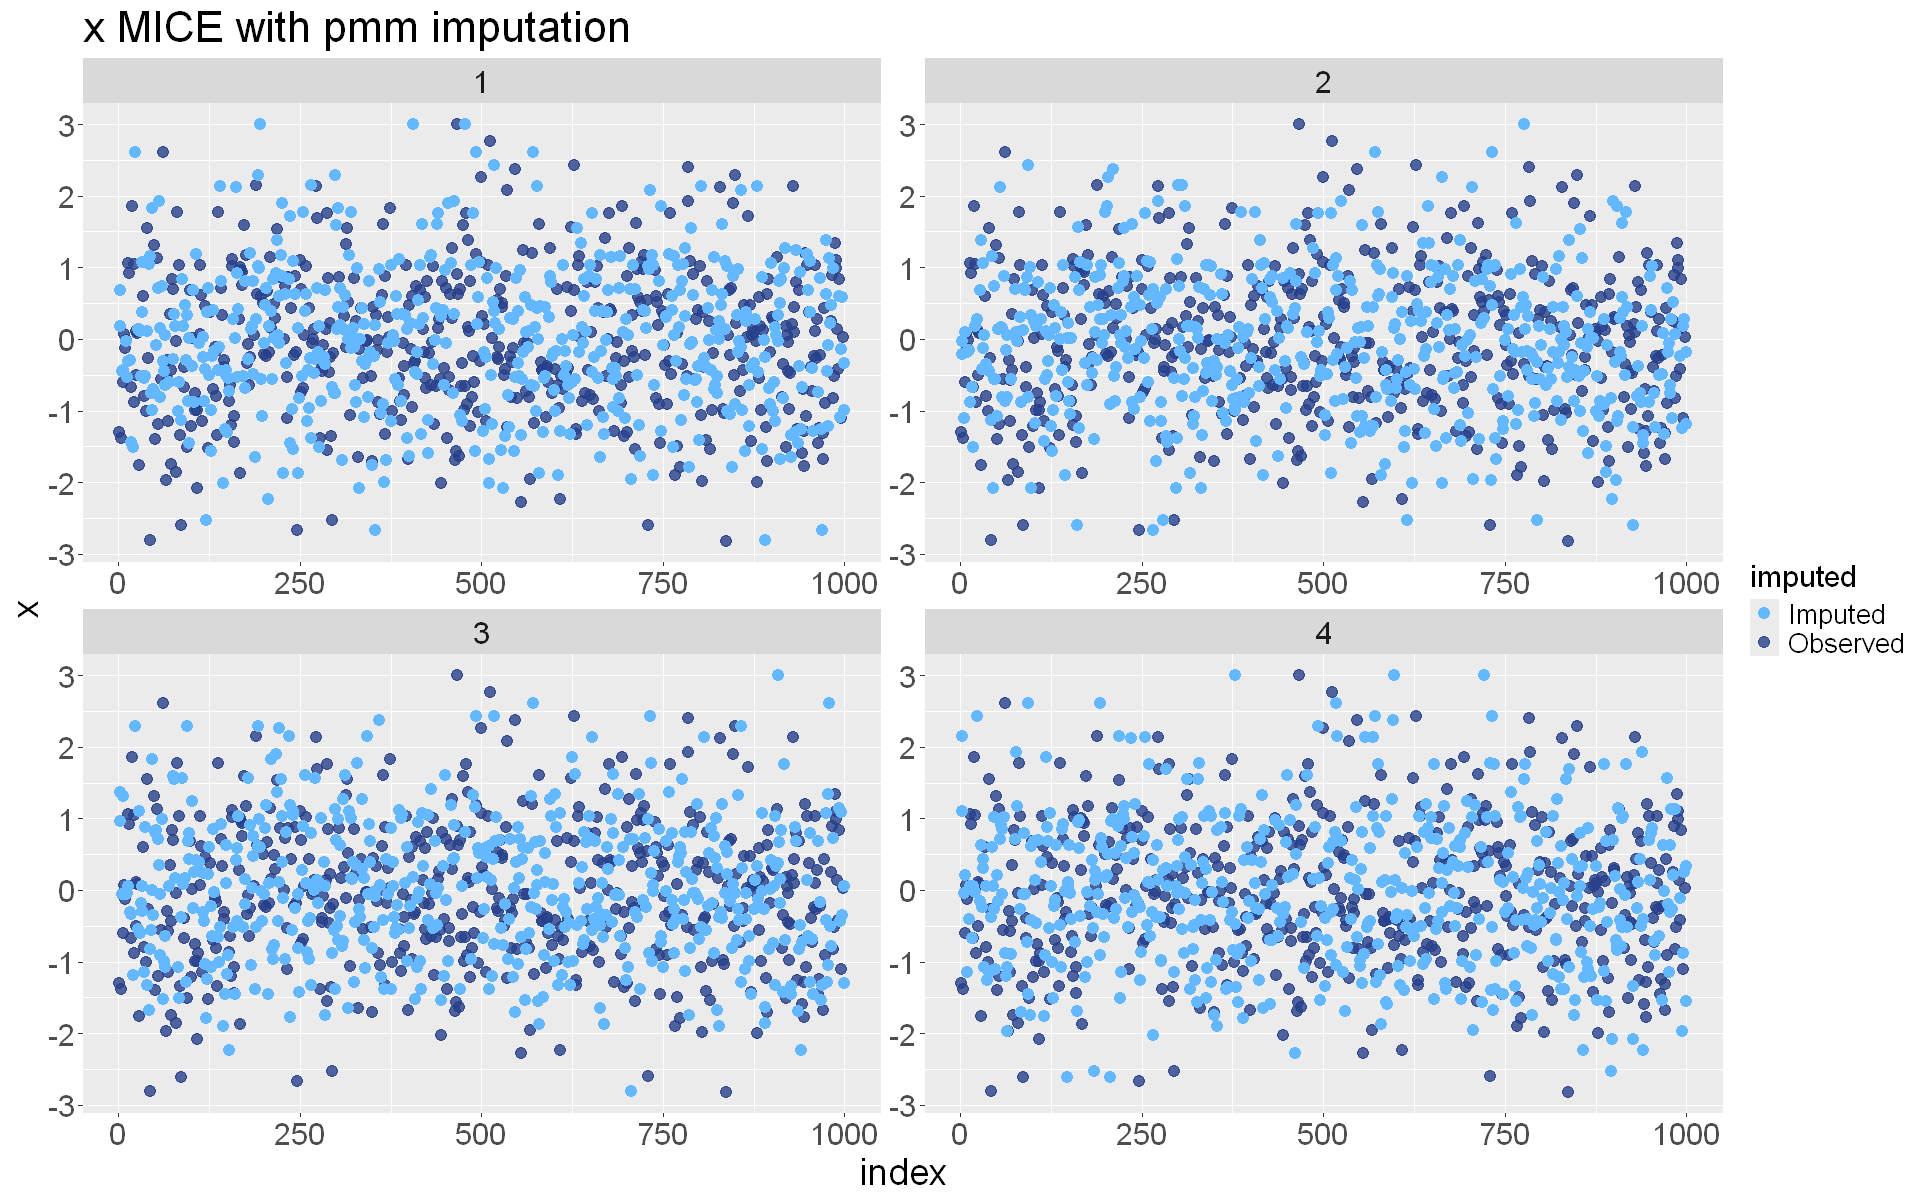

In [121]:
visImpMul(num1_stack, num1_mice_pmm, "x", "MICE with pmm")

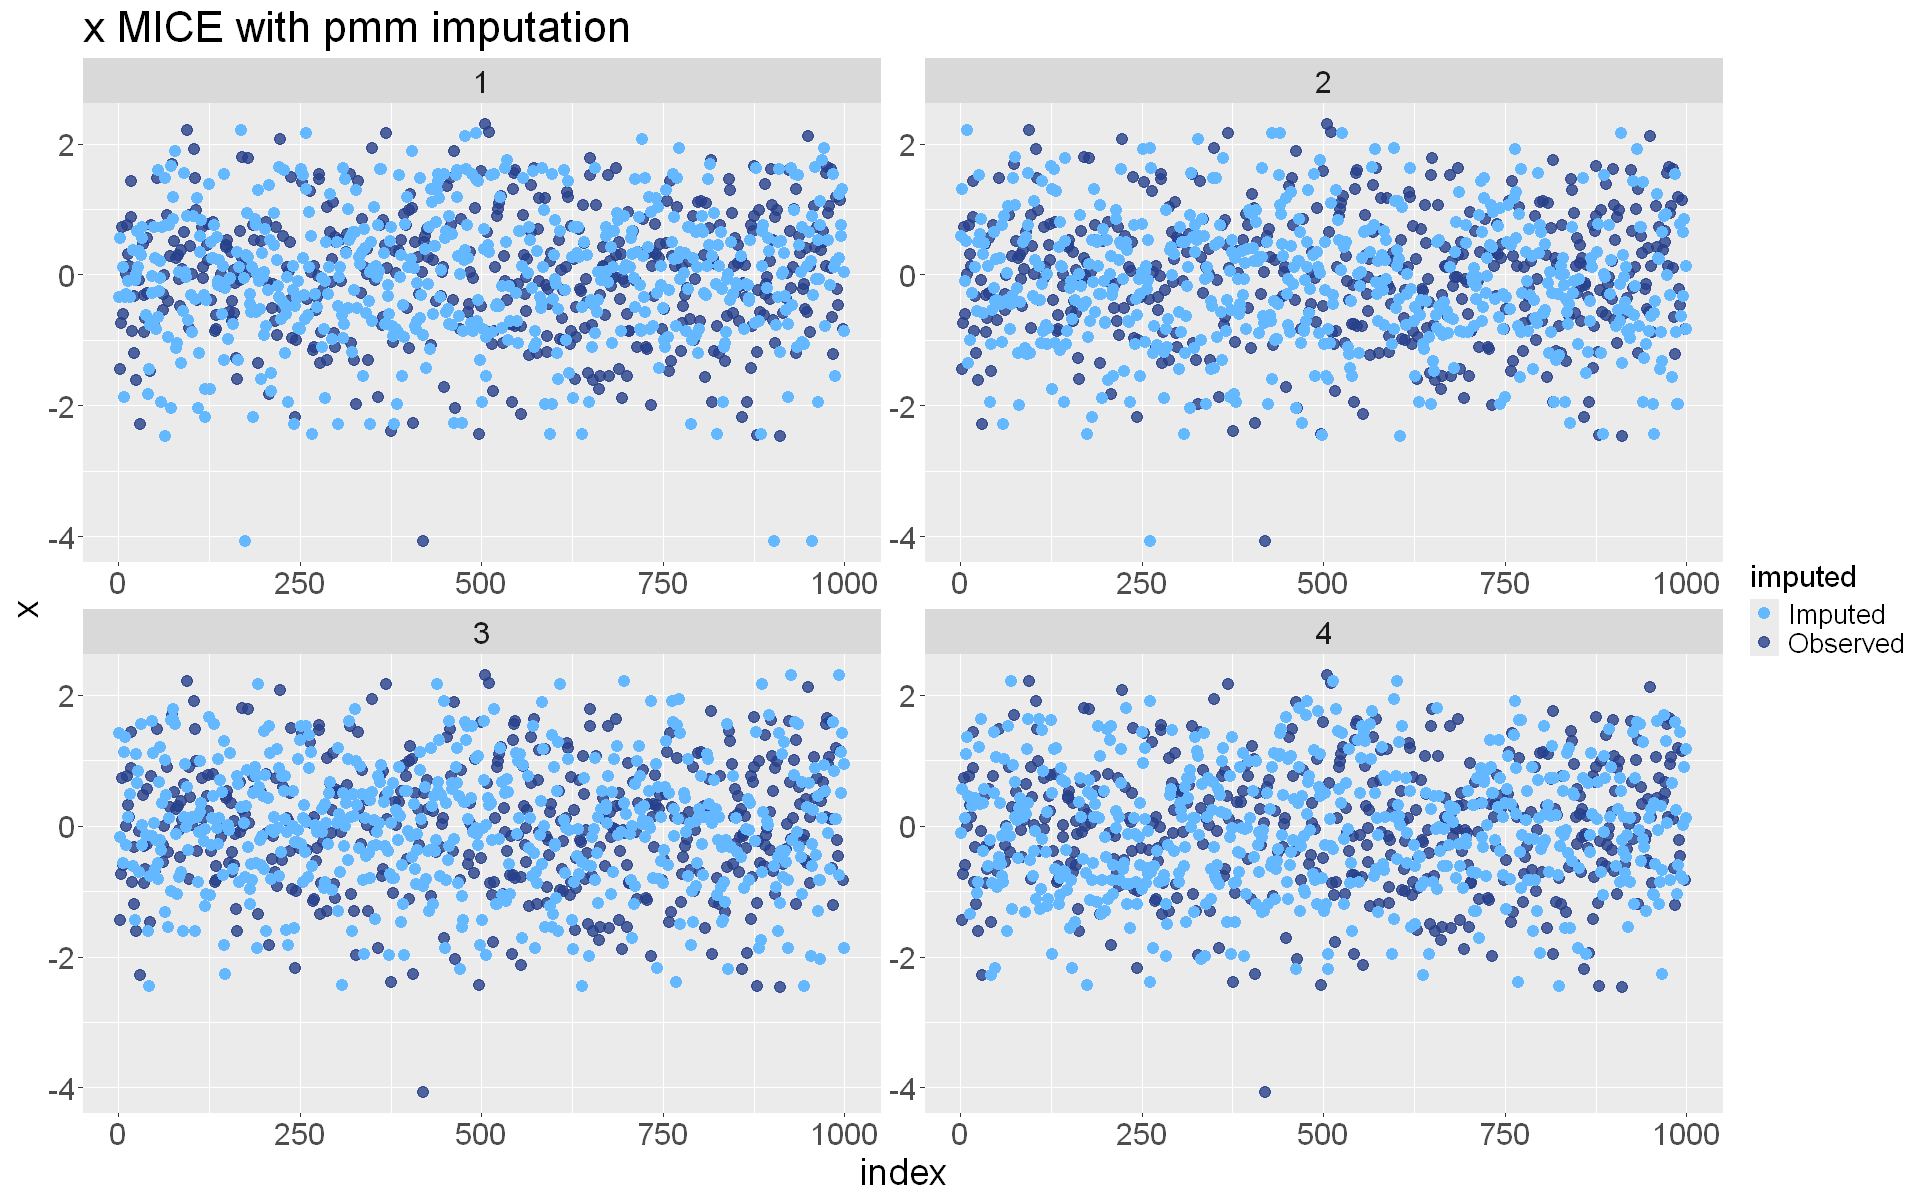

In [122]:
visImpMul(num2_stack, num2_mice_pmm, "x", "MICE with pmm")

In [123]:
num1_knn <- knnImputation(num1, scale=FALSE)
num2_knn <- knnImputation(num2, scale=FALSE)

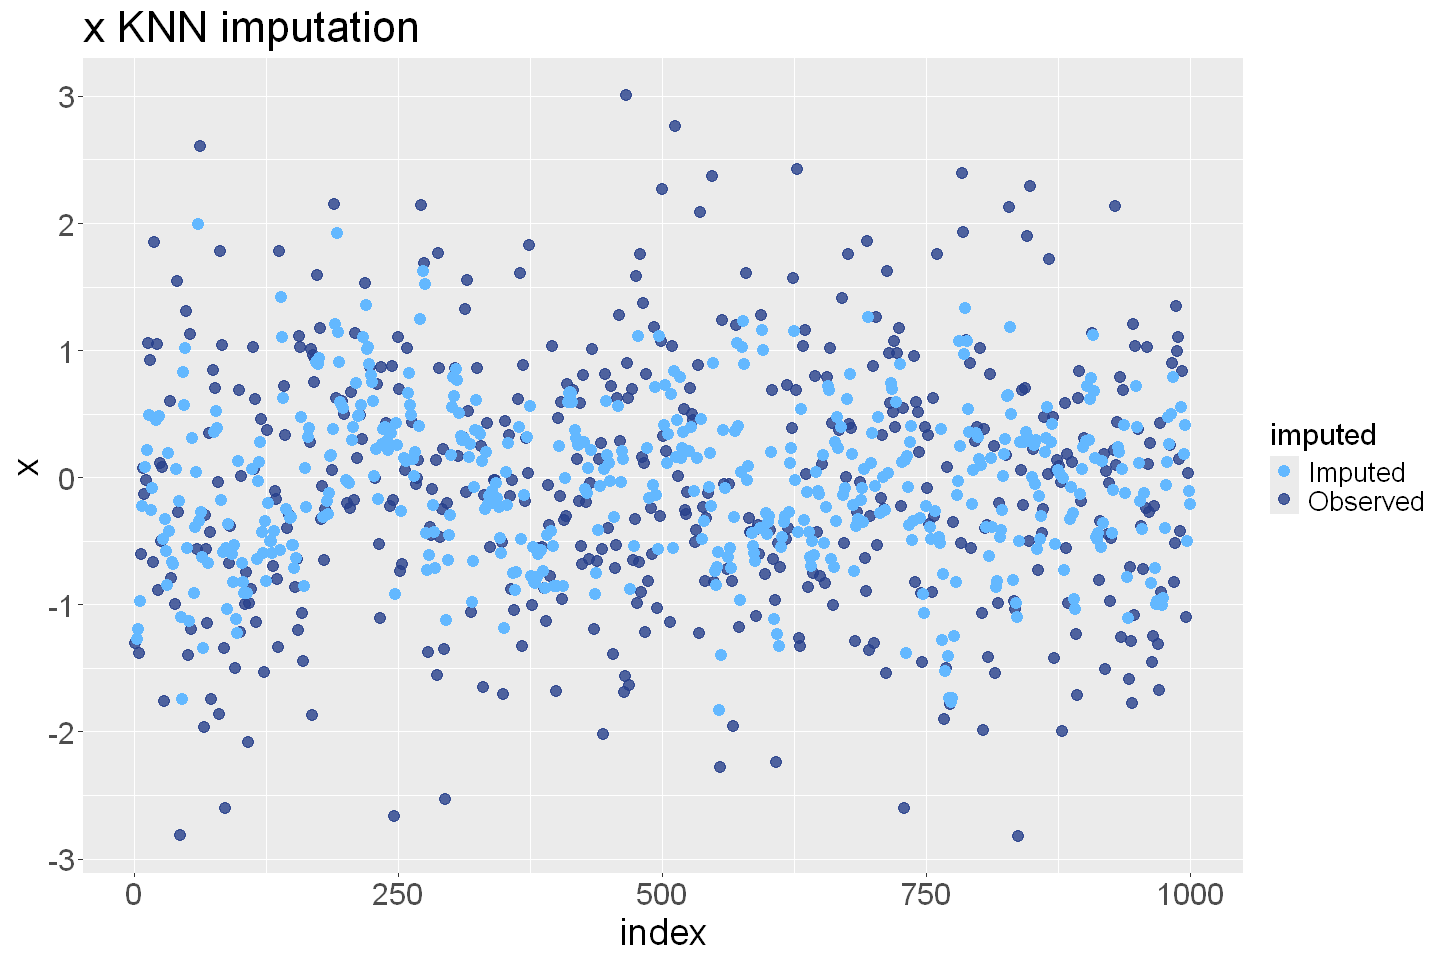

In [124]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(num1, num1_knn, "x", "KNN")

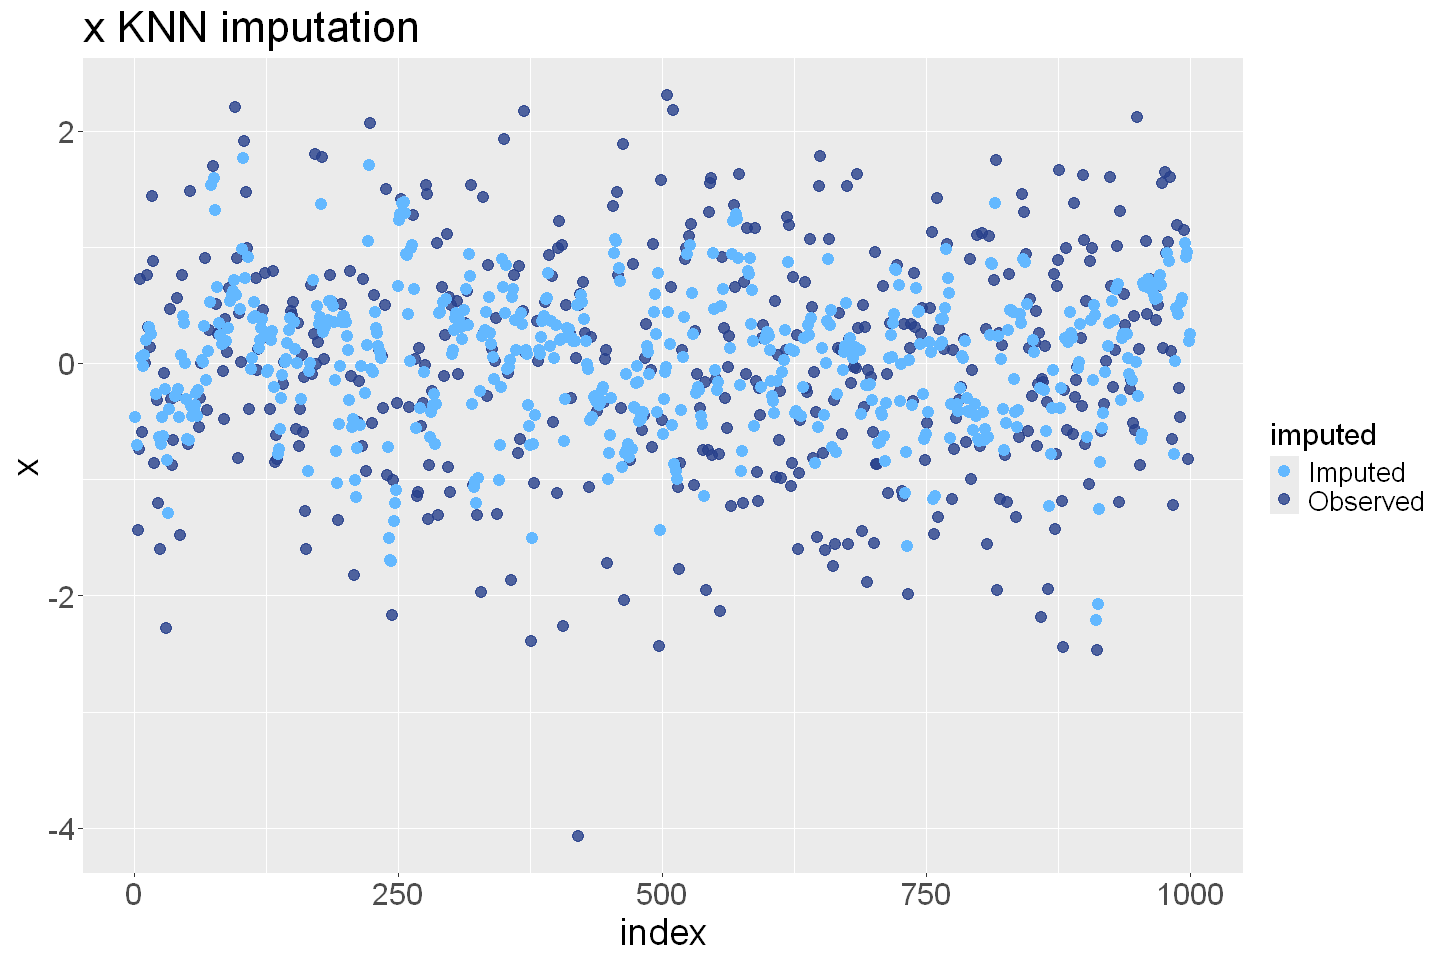

In [125]:
visImpCont(num2, num2_knn, "x", "KNN")

In [126]:
num1_mlmi <- normImp(obsData = num1, M = 4, rseed = 1234)
num2_mlmi <- normImp(obsData = num2, M = 4, rseed = 1234)

Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...


Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...


In [127]:
num1_mlmi_con <- num1_mlmi[[1]]
num2_mlmi_con <- num2_mlmi[[1]]
num1_mlmi_con$.imp <- 1
num2_mlmi_con$.imp <- 1

for (i in 2:4) {
    n1 <- num1_mlmi[[i]]
    n2 <- num2_mlmi[[i]]
    n1$.imp <- i
    n2$.imp <- i
    n1$index <- num1$index
    n2$index <- num2$index
    num1_mlmi_con <- rbind(num1_mlmi_con, n1)
    num2_mlmi_con <- rbind(num2_mlmi_con, n2)
}

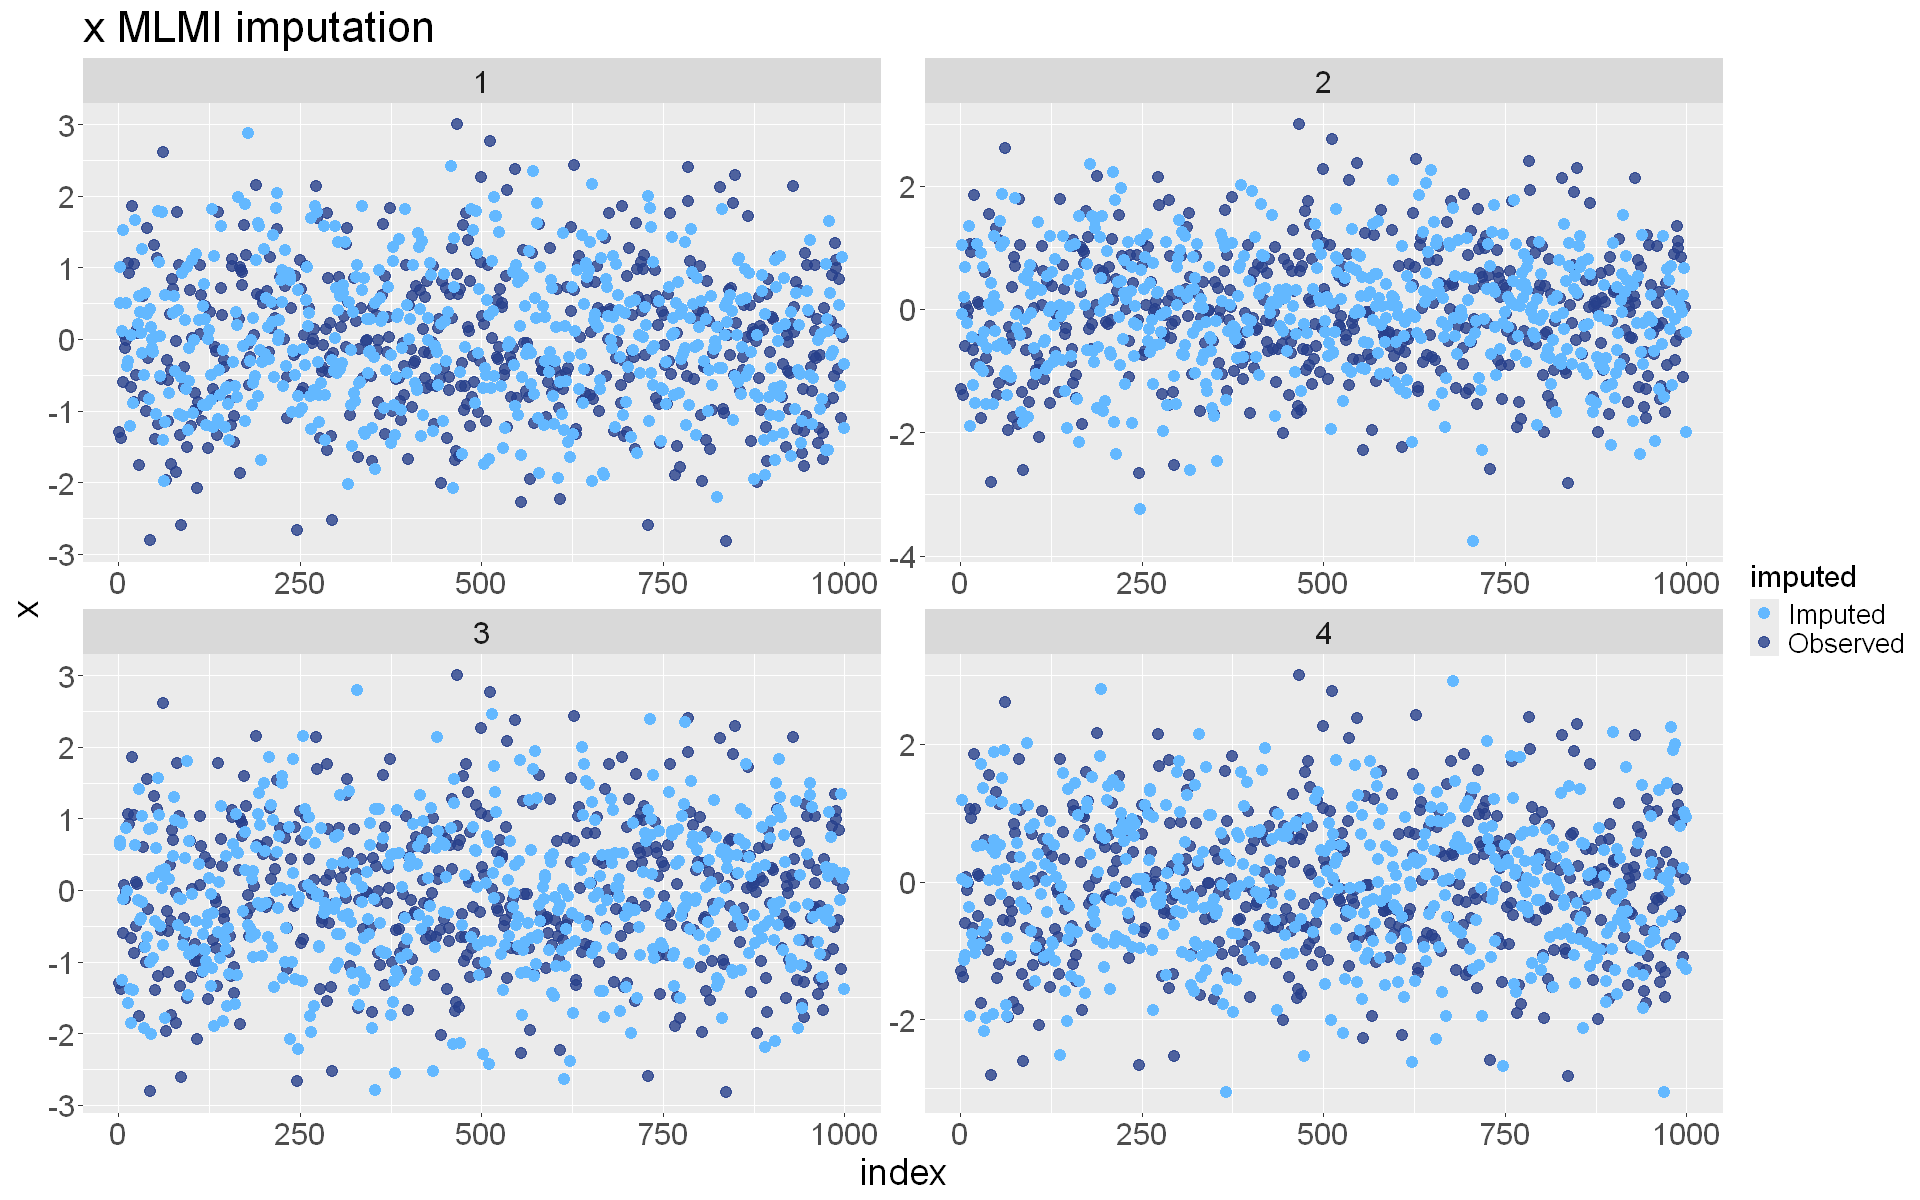

In [128]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(num1_stack, num1_mlmi_con, "x", "MLMI")

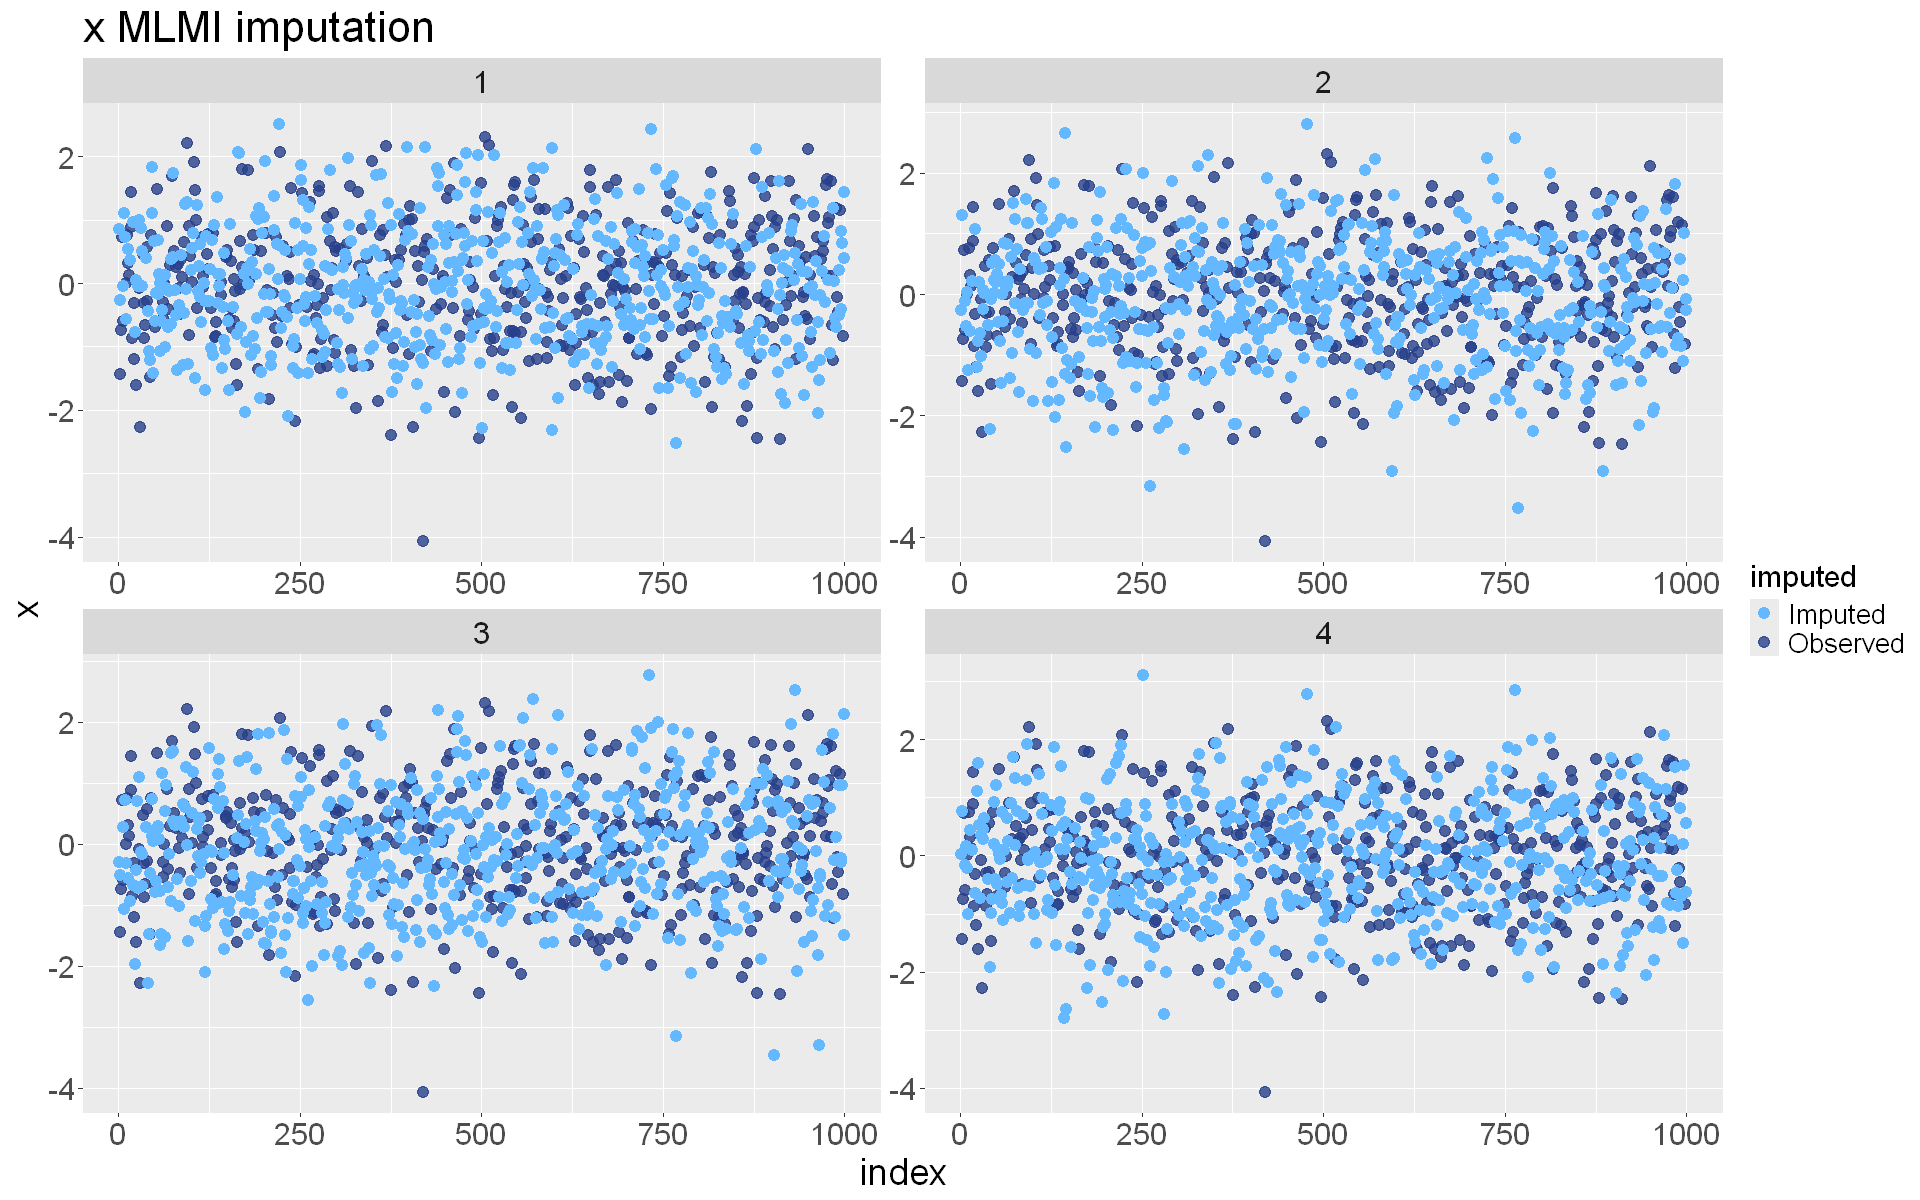

In [129]:
visImpMul(num2_stack, num2_mlmi_con, "x", "MLMI")

In [130]:
method10 <- c("cart", "", "", "")
num1_dt <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()
num2_dt <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()


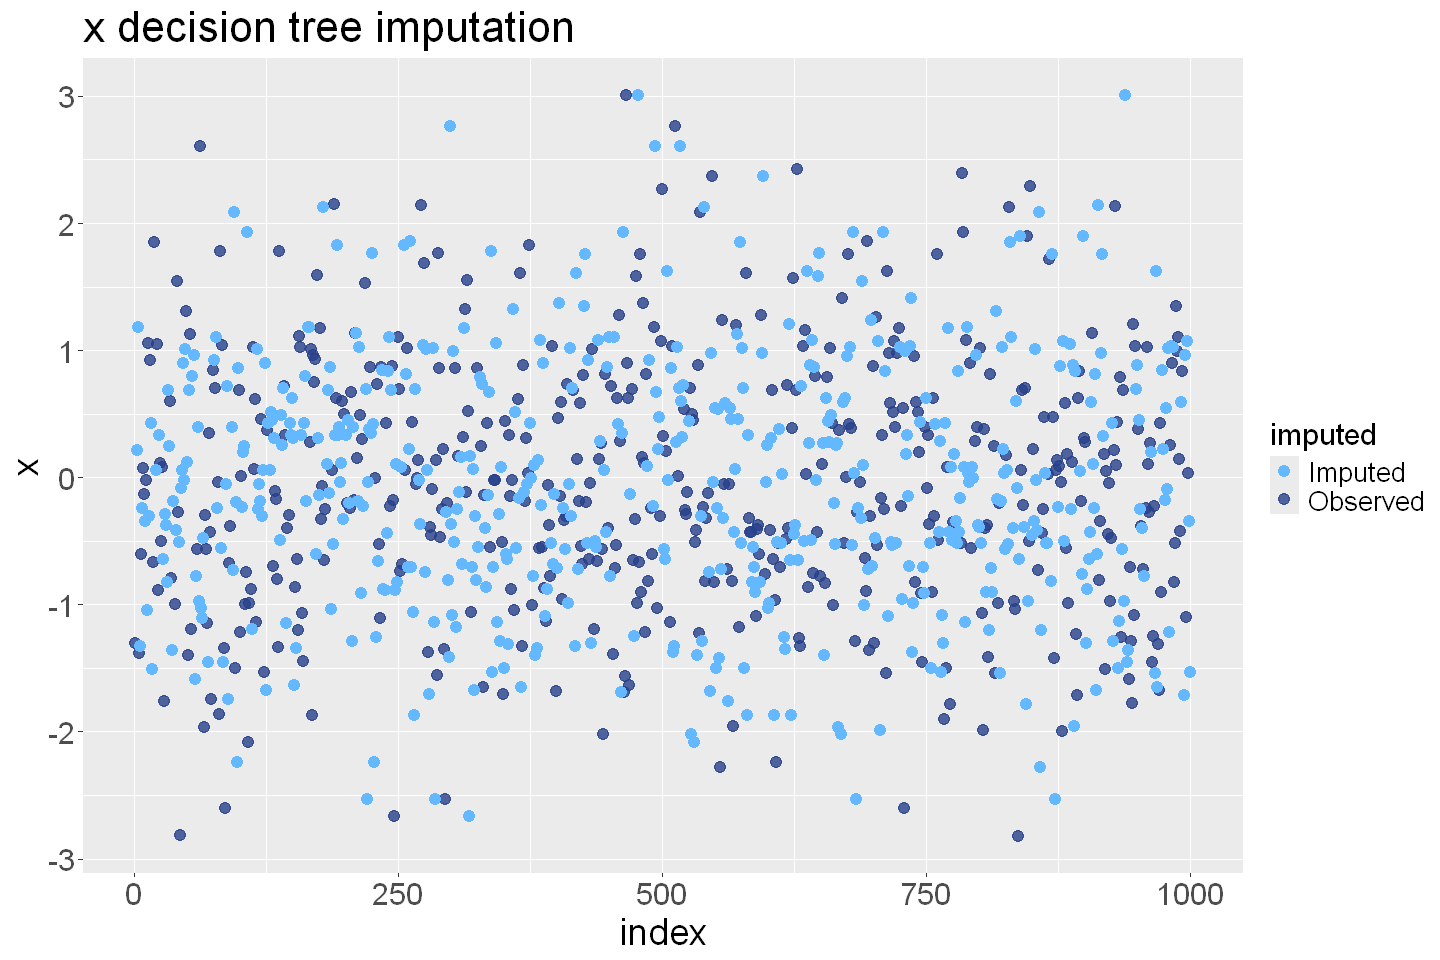

In [131]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(num1, num1_dt, "x", "decision tree")

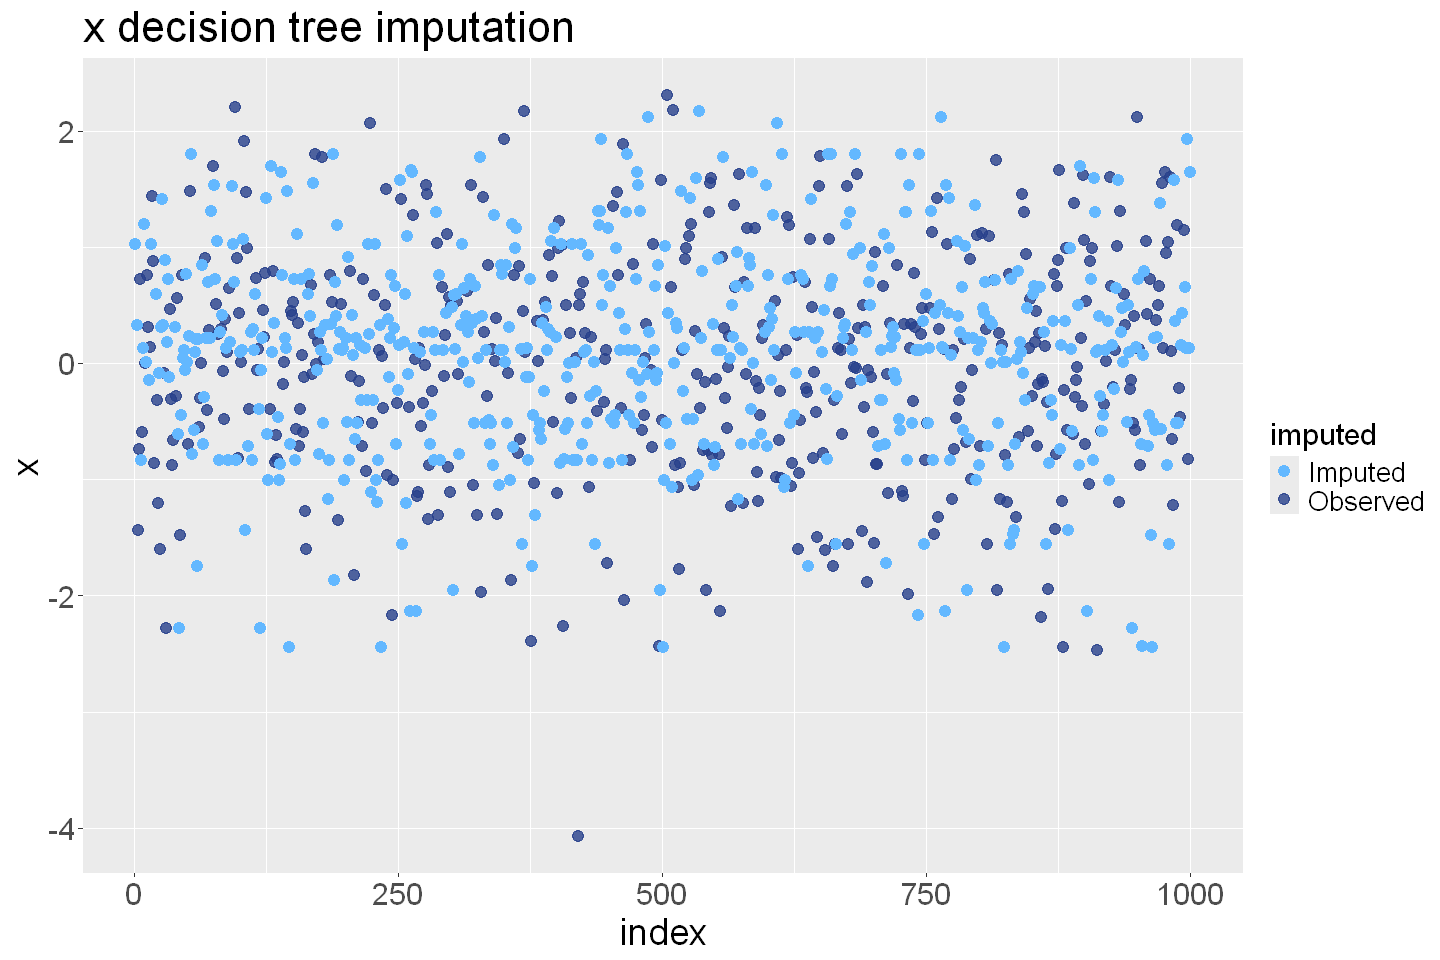

In [132]:
visImpCont(num2, num2_dt, "x", "decision tree")

In [133]:
method11 <- c("rf", "", "", "")
num1_rf <- mice(data = num1, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()
num2_rf <- mice(data = num2, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()

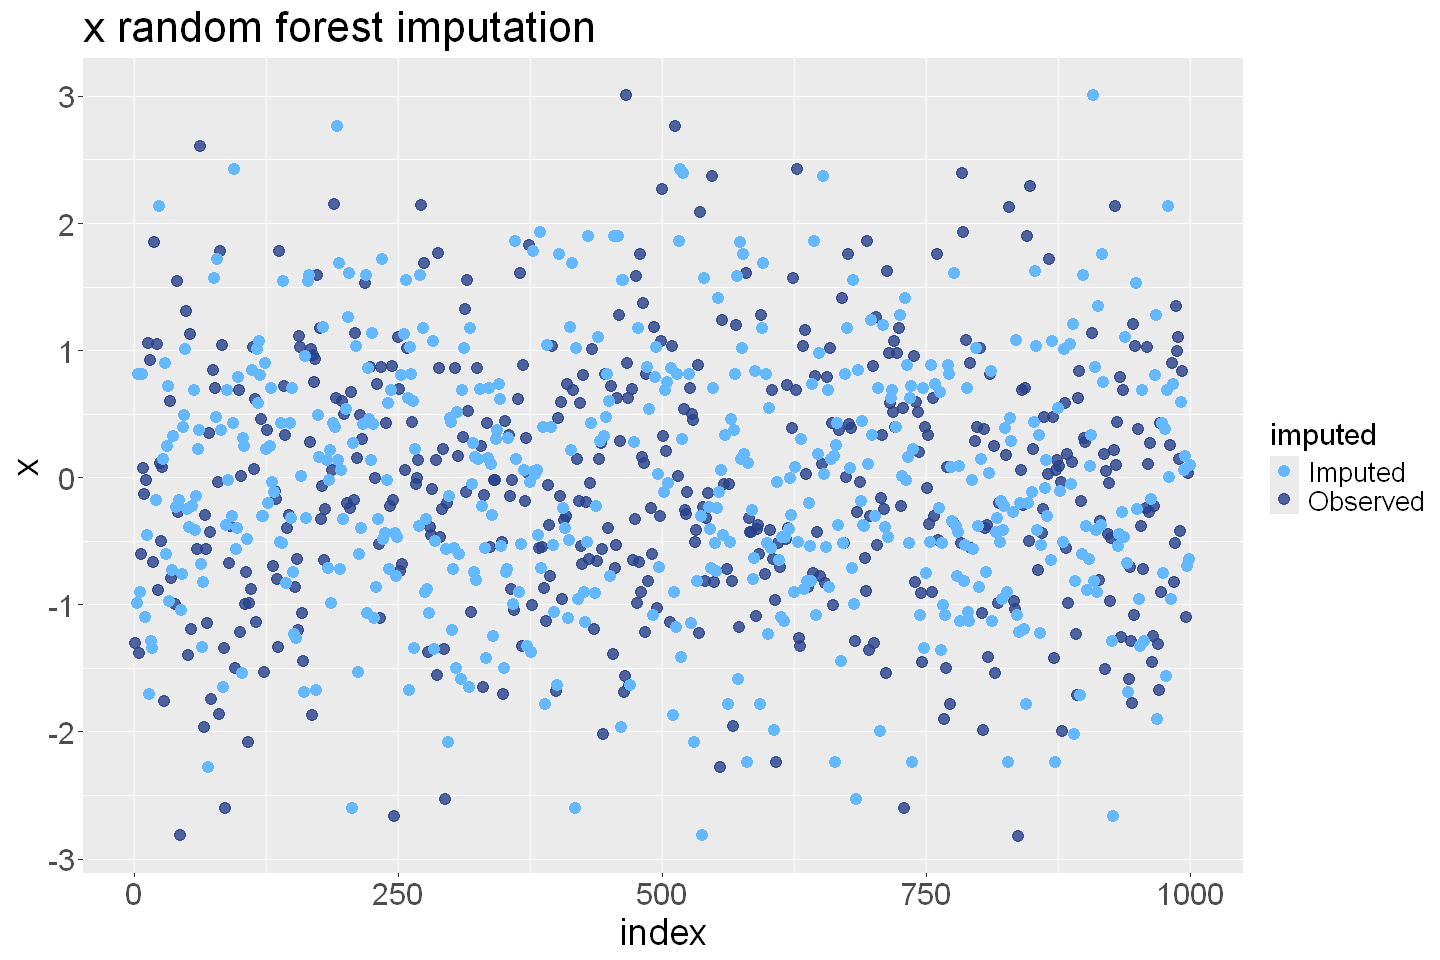

In [134]:
visImpCont(num1, num1_rf, "x", "random forest")

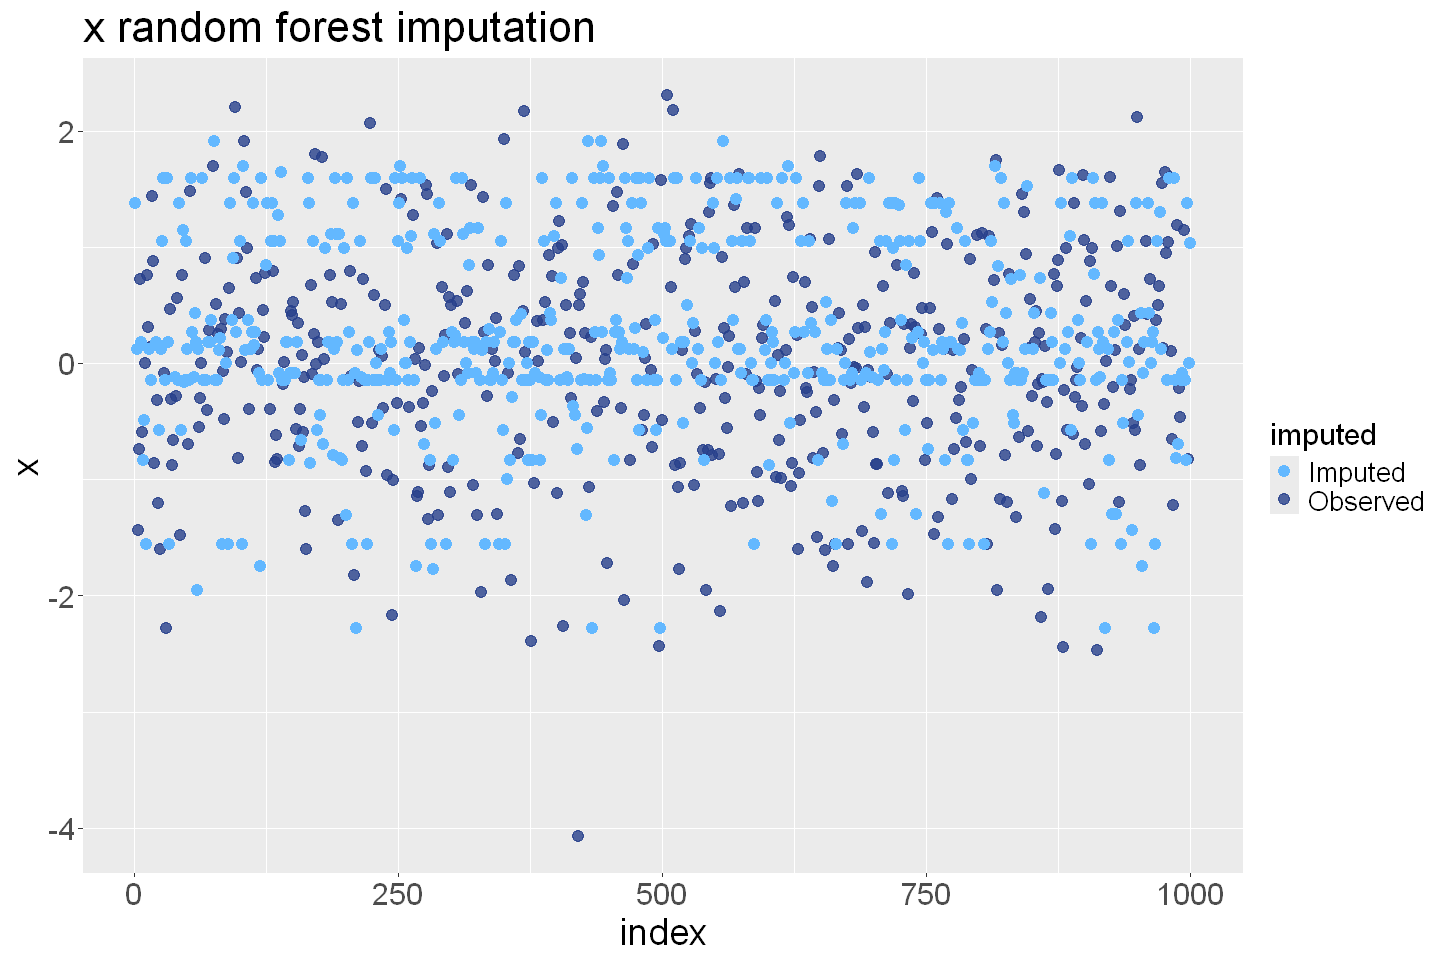

In [135]:
visImpCont(num2, num2_rf, "x", "random forest")

In [136]:
method12 <- c("logreg", "", "", "")
cat1_logreg <- mice(data = cat1, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()
cat2_logreg <- mice(data = cat2, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()

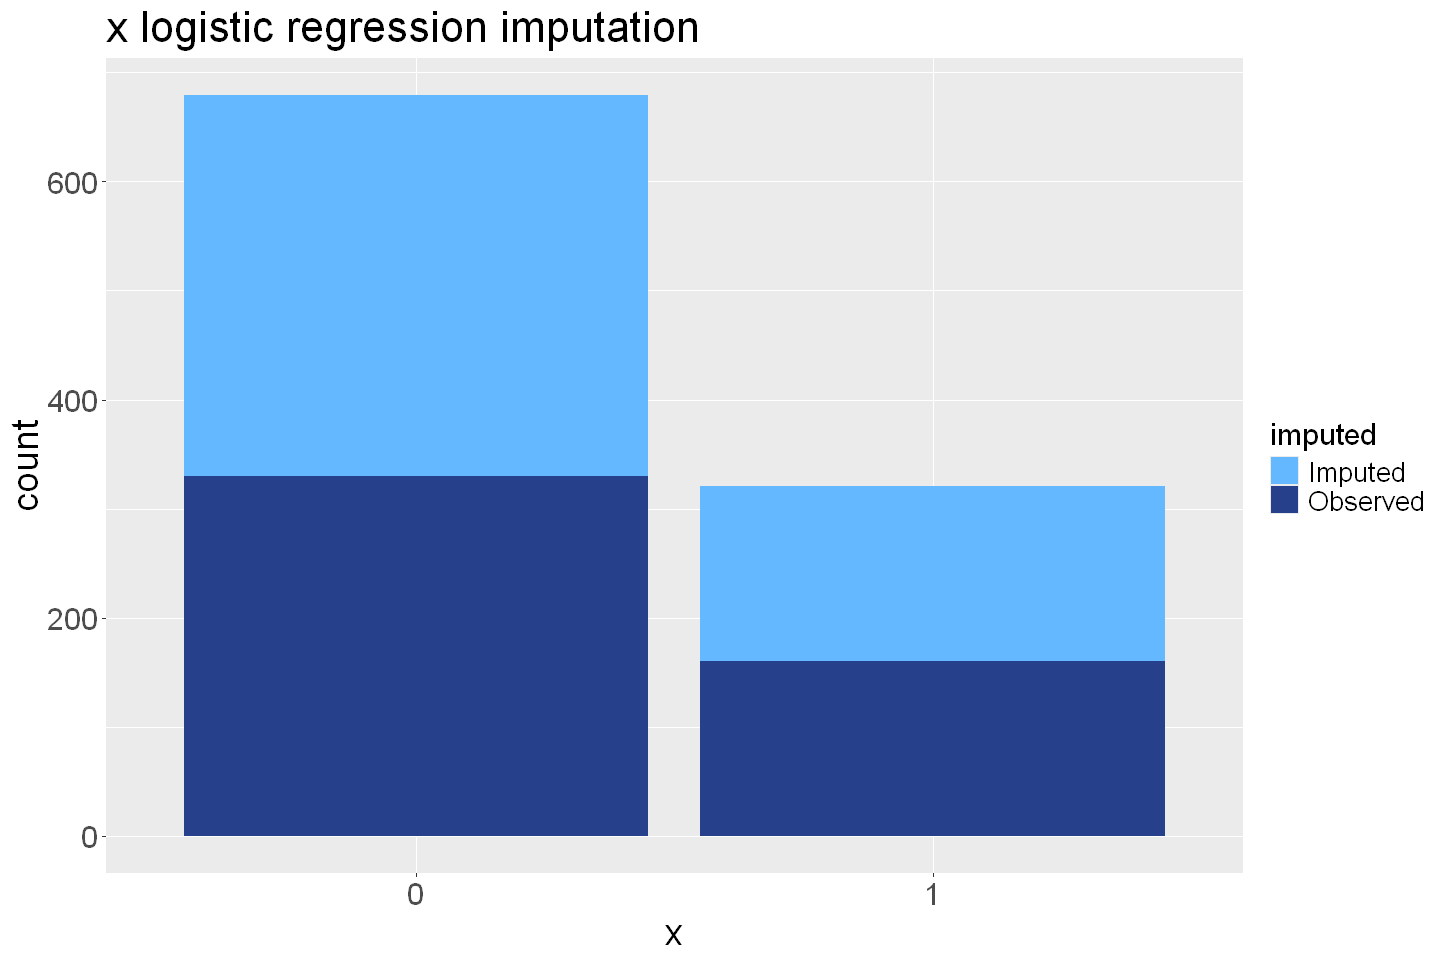

In [137]:
visImpCat(cat1, cat1_logreg, "x", "logistic regression")

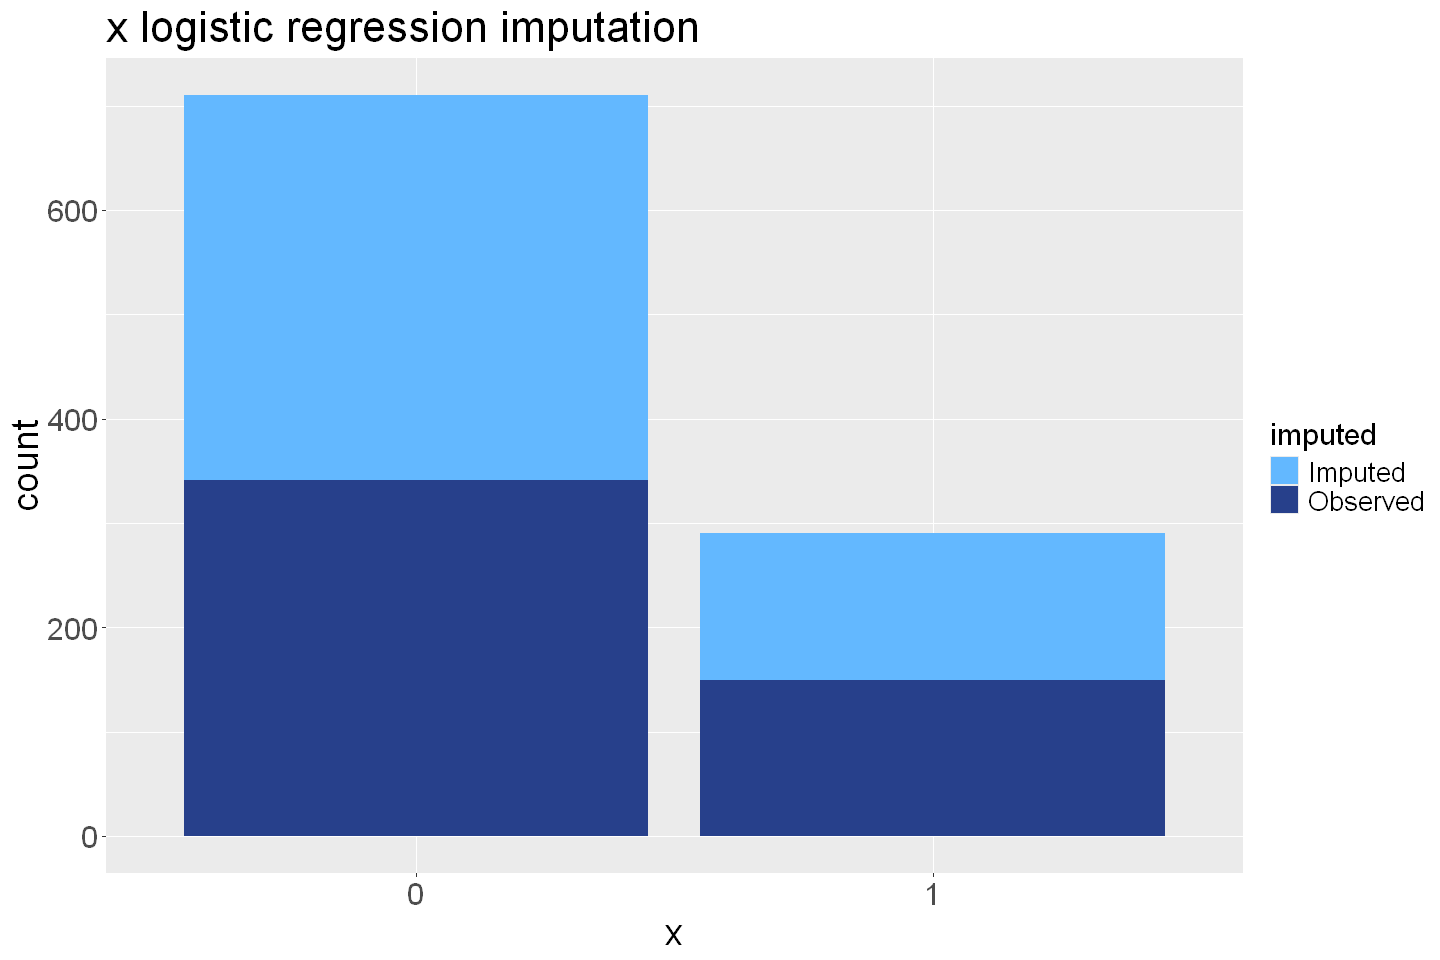

In [138]:
visImpCat(cat2, cat2_logreg, "x", "logistic regression")

In [139]:
cat1_knn <- knnImputation(cat1, scale=FALSE)
cat2_knn <- knnImputation(cat2, scale=FALSE)

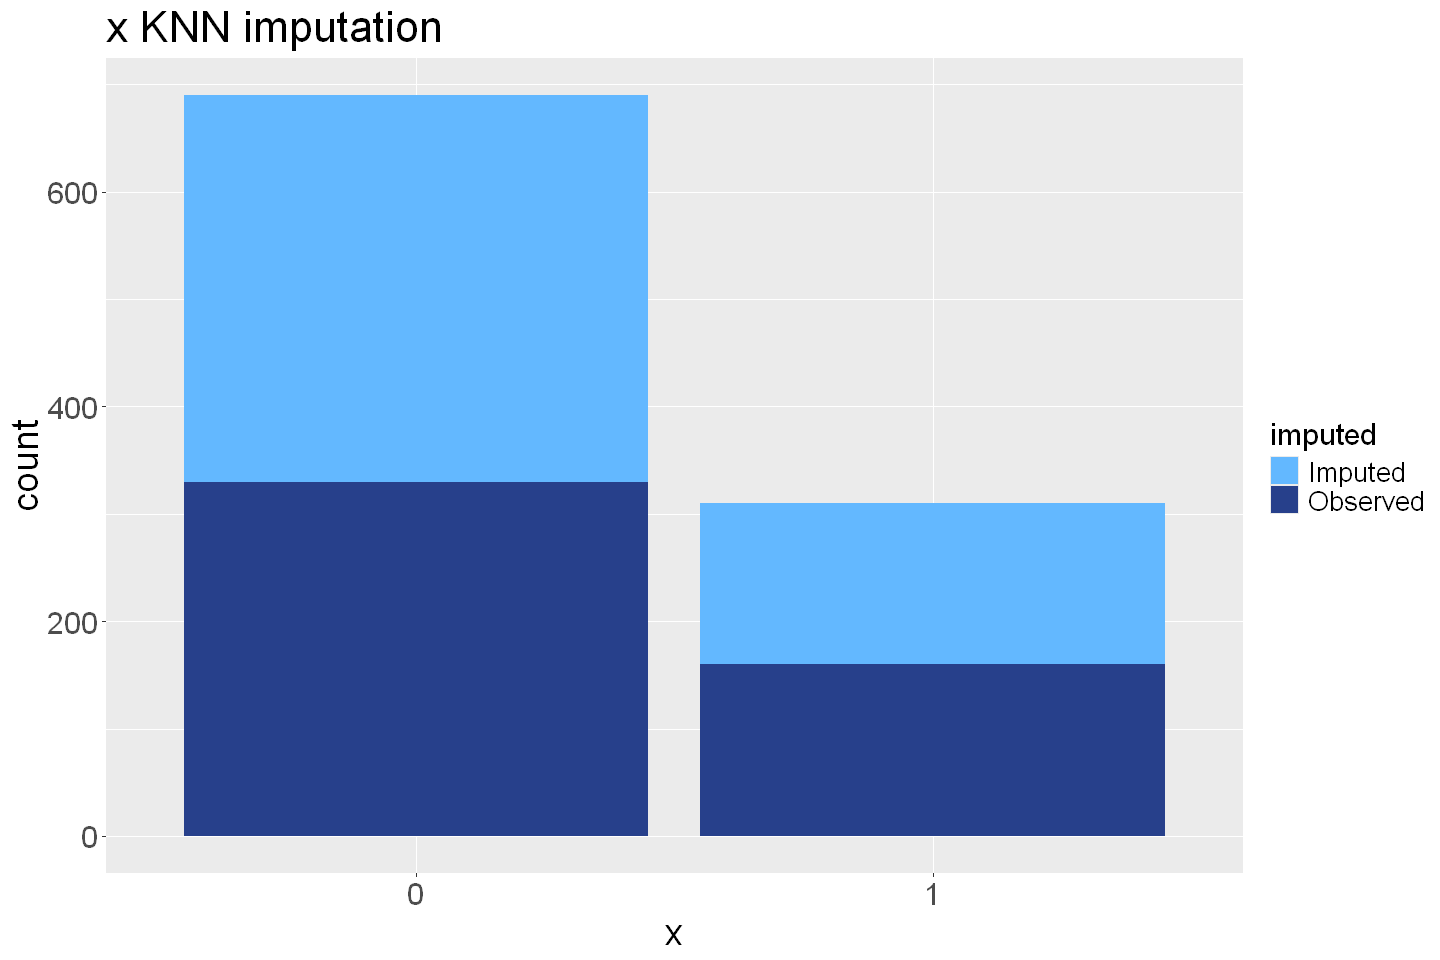

In [140]:
visImpCat(cat1, cat1_knn, "x", "KNN")

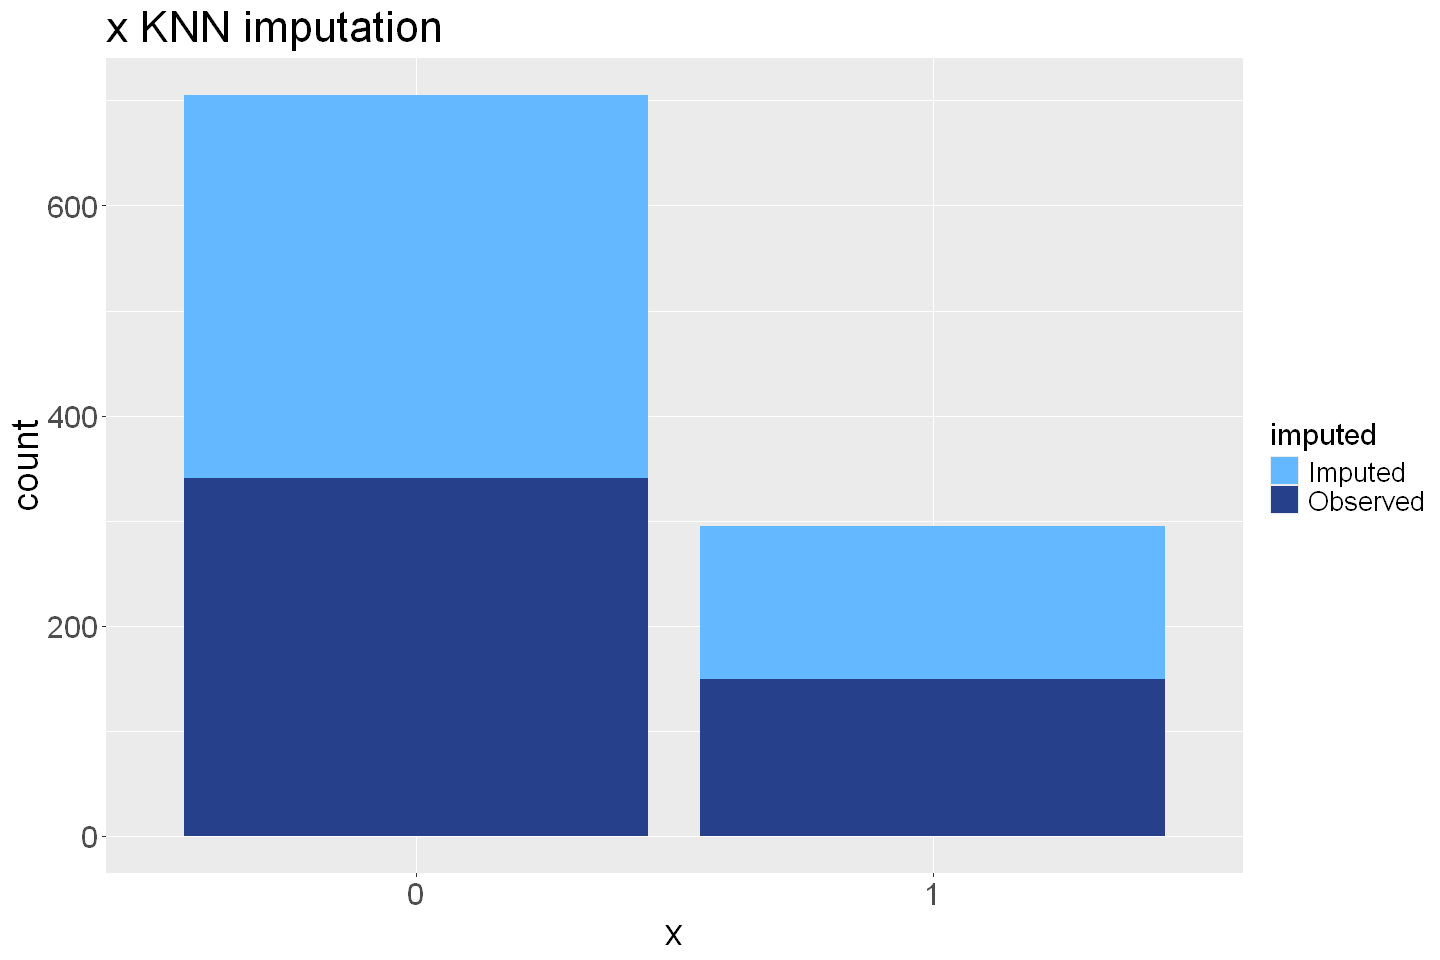

In [141]:
visImpCat(cat2, cat2_knn, "x", "KNN")

In [142]:
method14 <- c("cart", "", "", "")
cat1_dt <- mice(data = cat1, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()
cat2_dt <- mice(data = cat2, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()

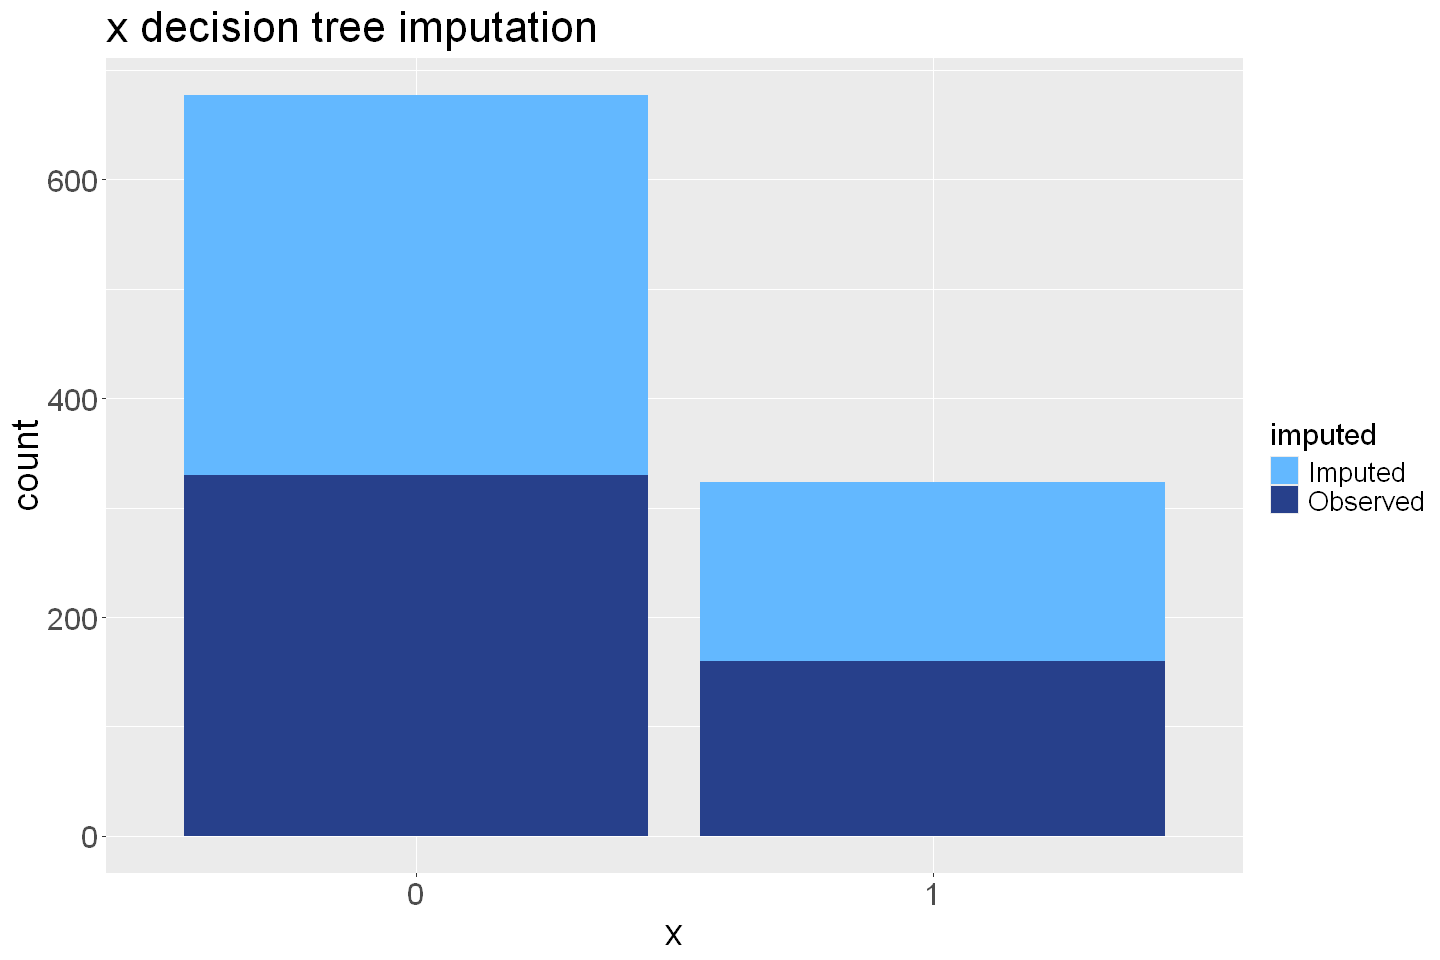

In [143]:
visImpCat(cat1, cat1_dt, "x", "decision tree")

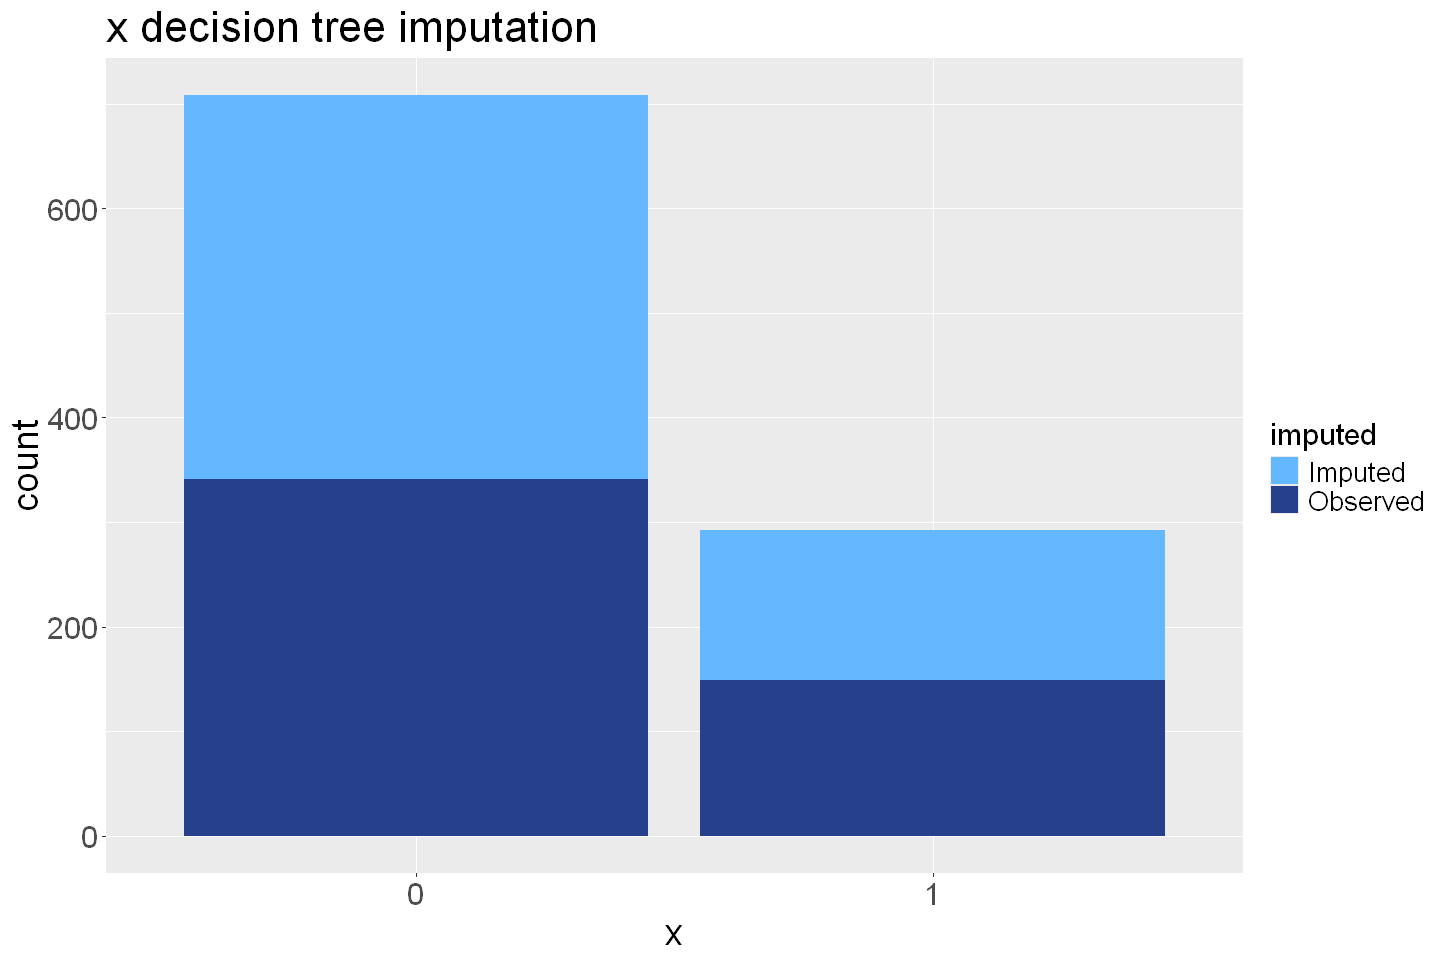

In [144]:
visImpCat(cat2, cat2_dt, "x", "decision tree")

In [145]:
method15 <- c("rf", "", "", "")
cat1_rf <- mice(data = cat1, m = 1, maxit = 1, printFlag = FALSE, method = method15, predictorMatrix = predm) %>% complete()
cat2_rf <- mice(data = cat2, m = 1, maxit = 1, printFlag = FALSE, method = method15, predictorMatrix = predm) %>% complete()

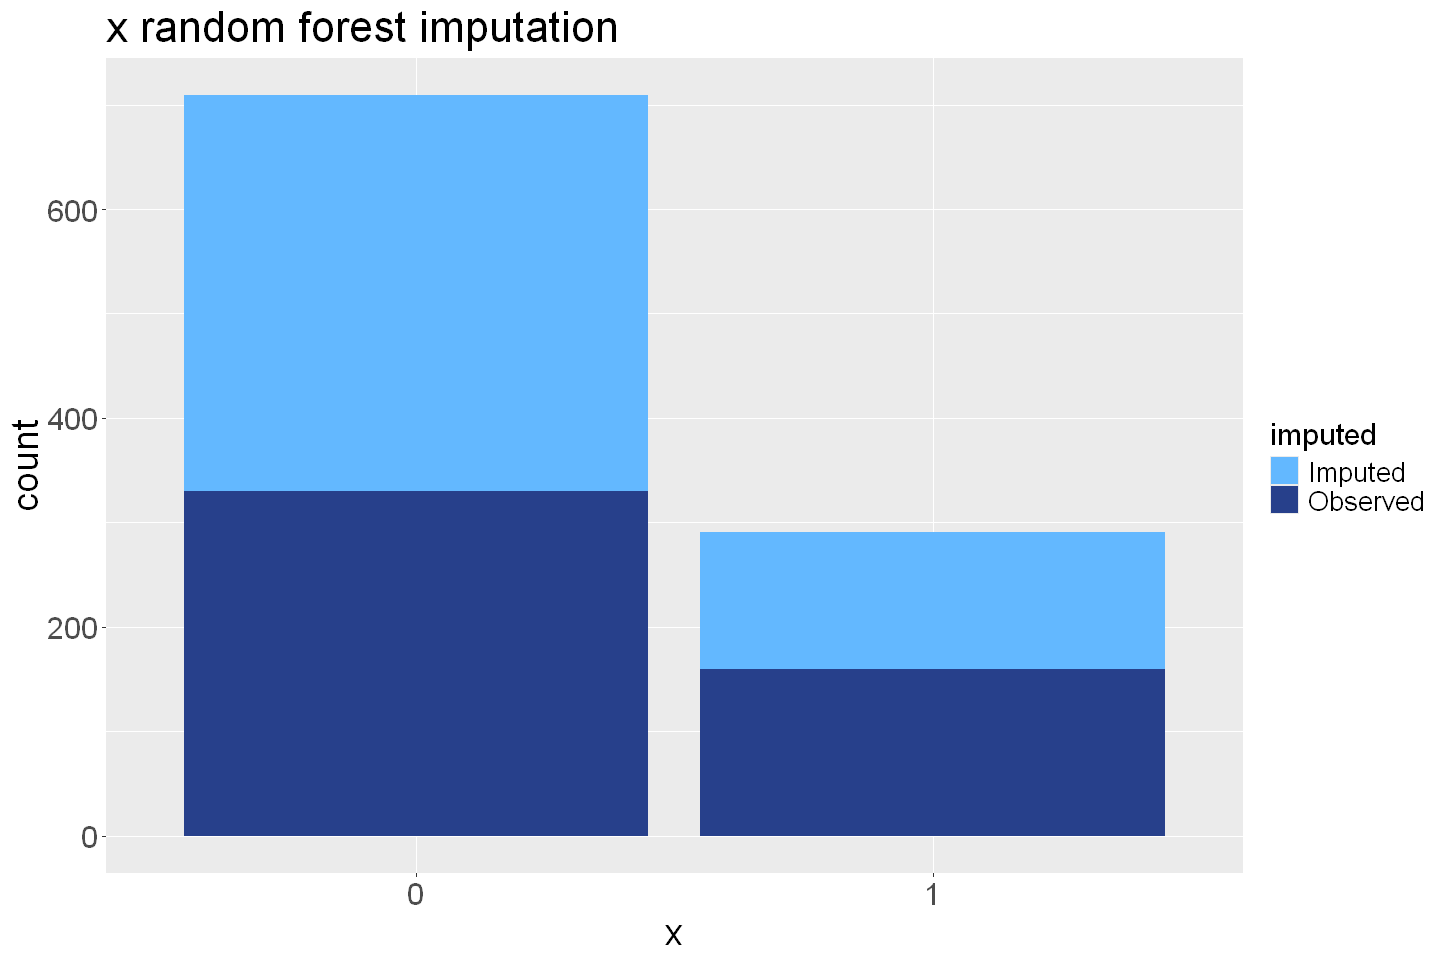

In [146]:
visImpCat(cat1, cat1_rf, "x", "random forest")

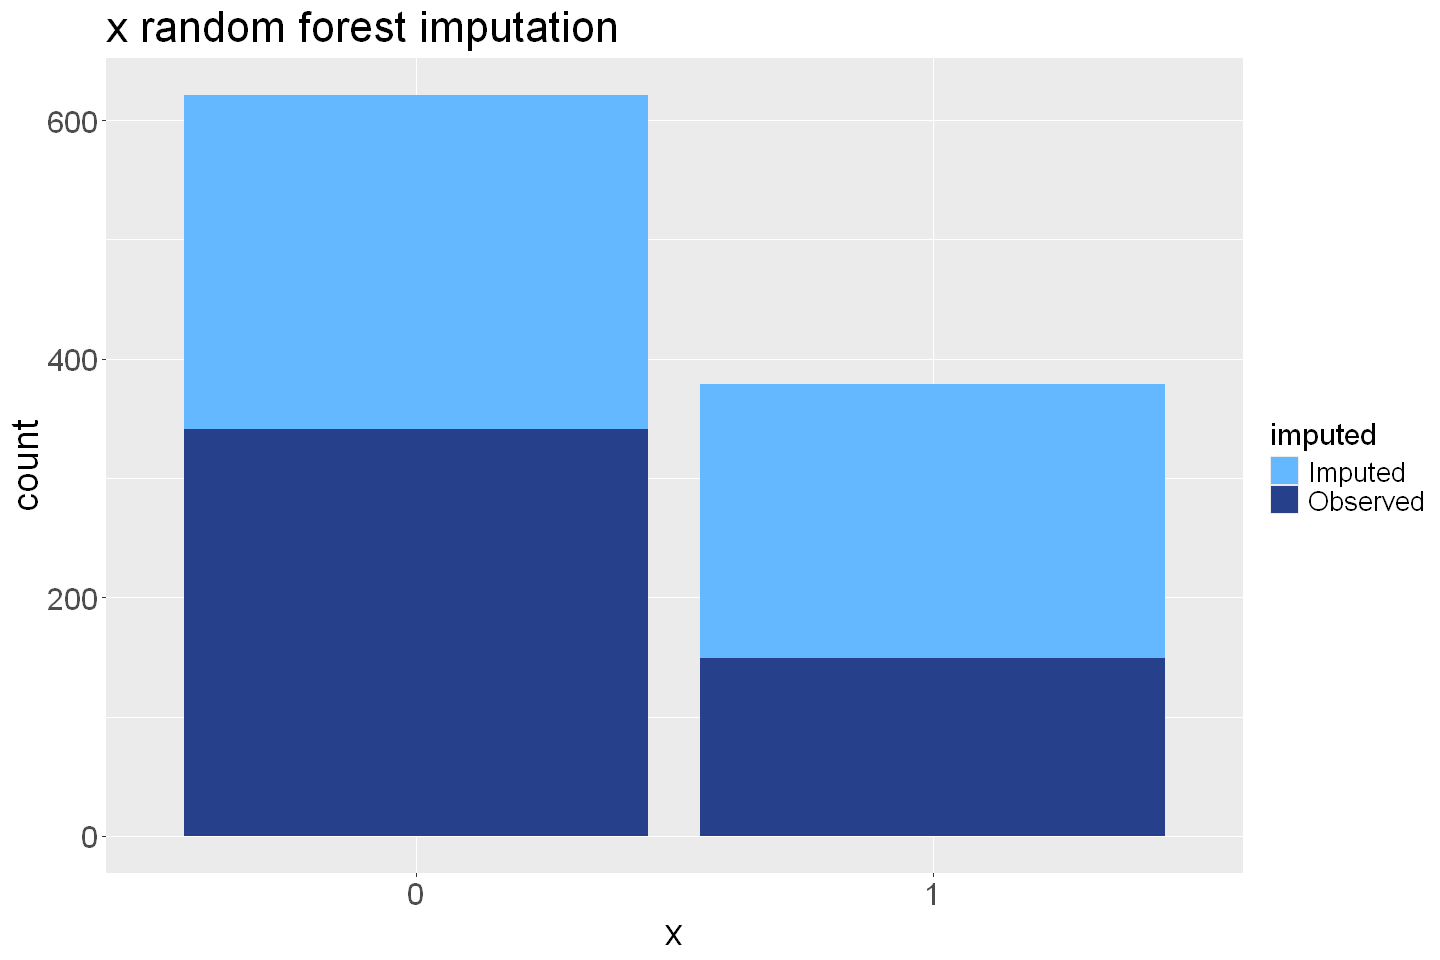

In [147]:
visImpCat(cat2, cat2_rf, "x", "random forest")

In [148]:
cat1_num <- cat1
cat2_num <- cat2
cat1_num$x <- as.factor(as.integer(cat1$x))
cat2_num$x <- as.factor(as.integer(cat2$x))

cat1_mlmi <- mixImp(obsData = cat1_num, M = 4, nCat = 1, rseed = 1234)
cat2_mlmi <- mixImp(obsData = cat2_num, M = 4, nCat = 1, rseed = 1234)

Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...


Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...


In [149]:
for (i in 1:4) {
    cat1_mlmi[[i]][] <- lapply(cat1_mlmi[[i]], function(x) as.numeric(as.character(x)))
    cat2_mlmi[[i]][] <- lapply(cat2_mlmi[[i]], function(x) as.numeric(as.character(x)))
    cat1_mlmi[[i]]$x <- as.factor(ifelse(cat1_mlmi[[i]]$x == "2", 1, 0))
    cat2_mlmi[[i]]$x <- as.factor(ifelse(cat2_mlmi[[i]]$x == "2", 1, 0))
}

In [150]:
cat1_mlmi_con <- cat1_mlmi[[1]]
cat2_mlmi_con <- cat2_mlmi[[1]]
cat1_mlmi_con$.imp <- 1
cat2_mlmi_con$.imp <- 1

for (i in 2:4) {
    n1 <- cat1_mlmi[[i]]
    n2 <- cat2_mlmi[[i]]
    n1$.imp <- i
    n2$.imp <- i
    n1$index <- cat1$index
    n2$index <- cat2$index
    cat1_mlmi_con <- rbind(cat1_mlmi_con, n1)
    cat2_mlmi_con <- rbind(cat2_mlmi_con, n2)
}


In [151]:
cat1_stack <- rbind(cat1, cat1, cat1, cat1)
cat2_stack <- rbind(cat2, cat2, cat2, cat2)

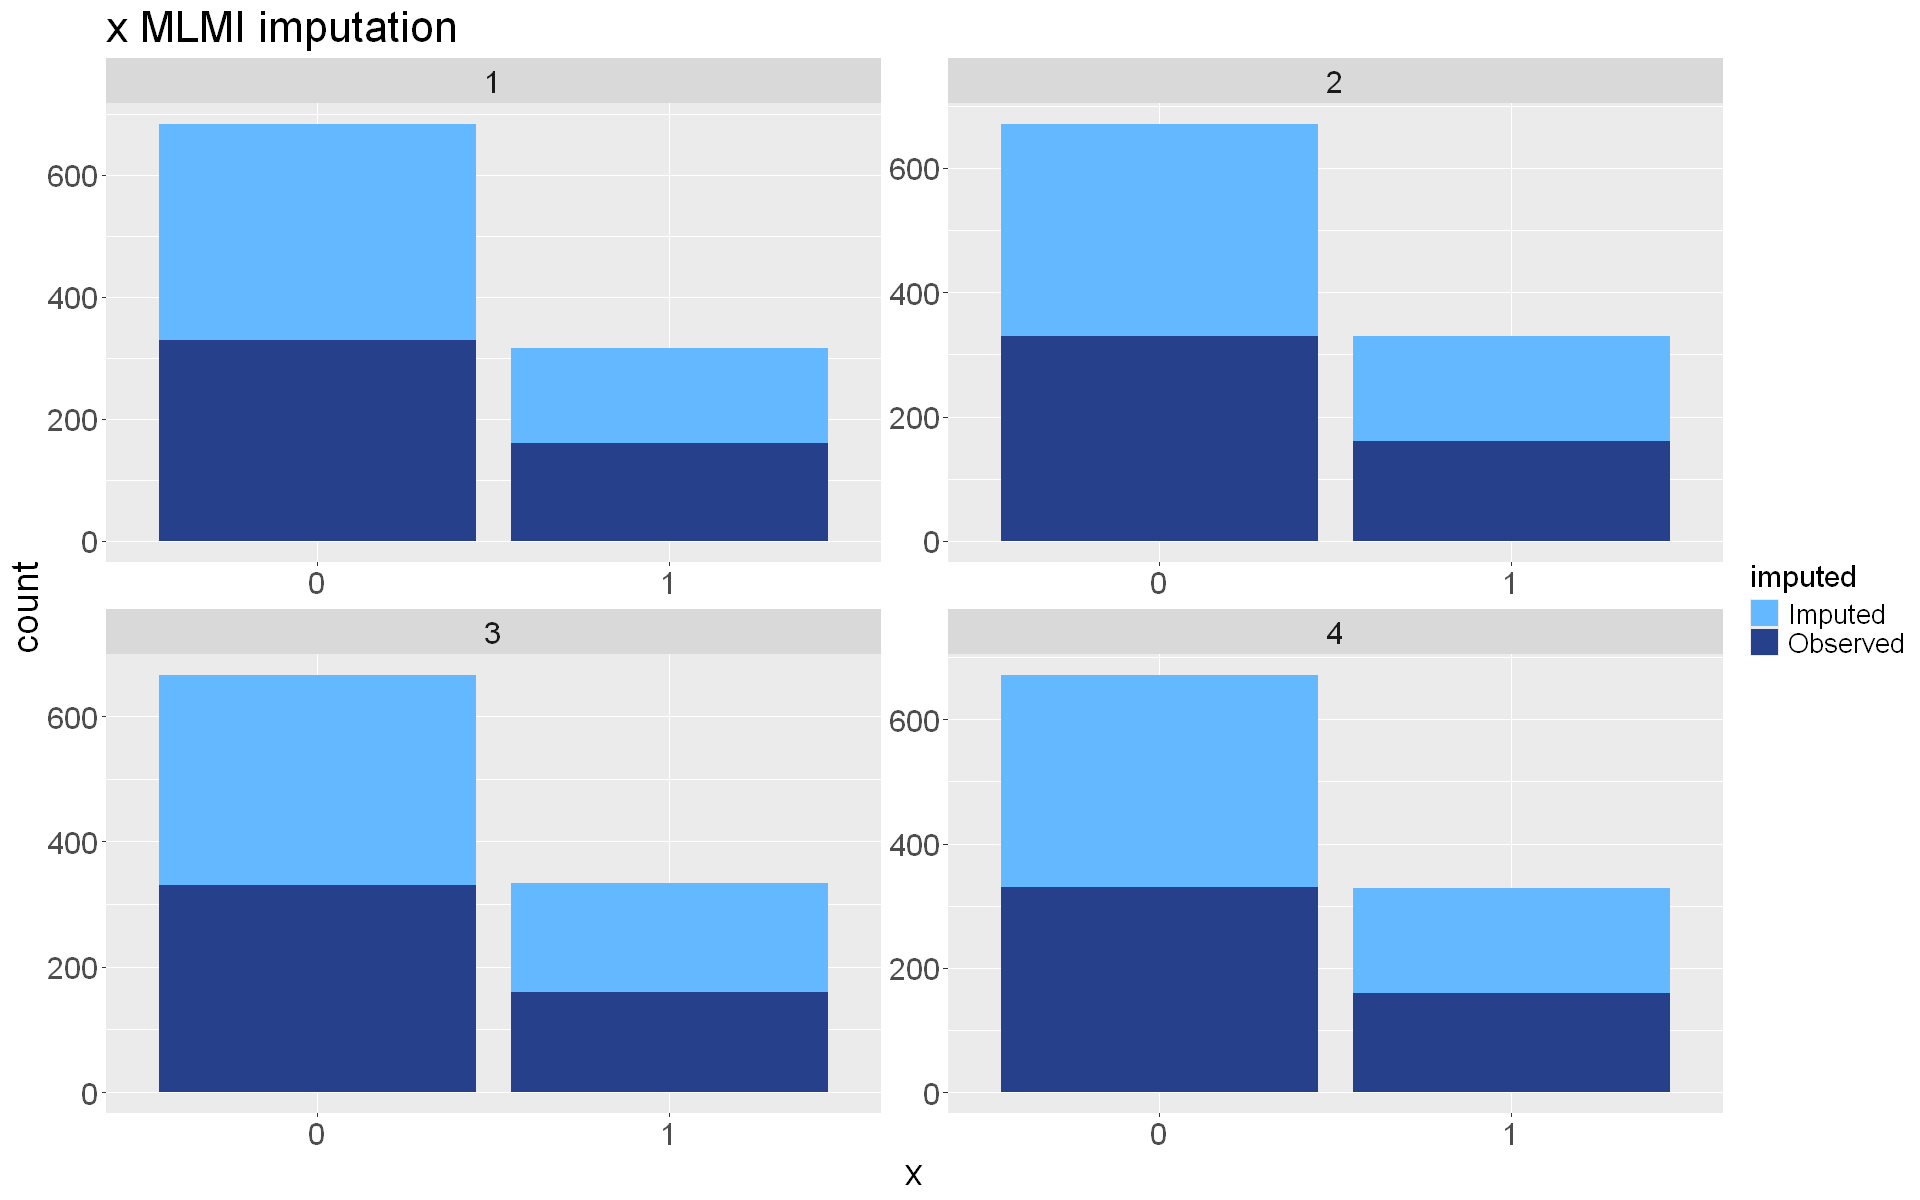

In [152]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMulCat(cat1_stack, cat1_mlmi_con, "x", "MLMI")

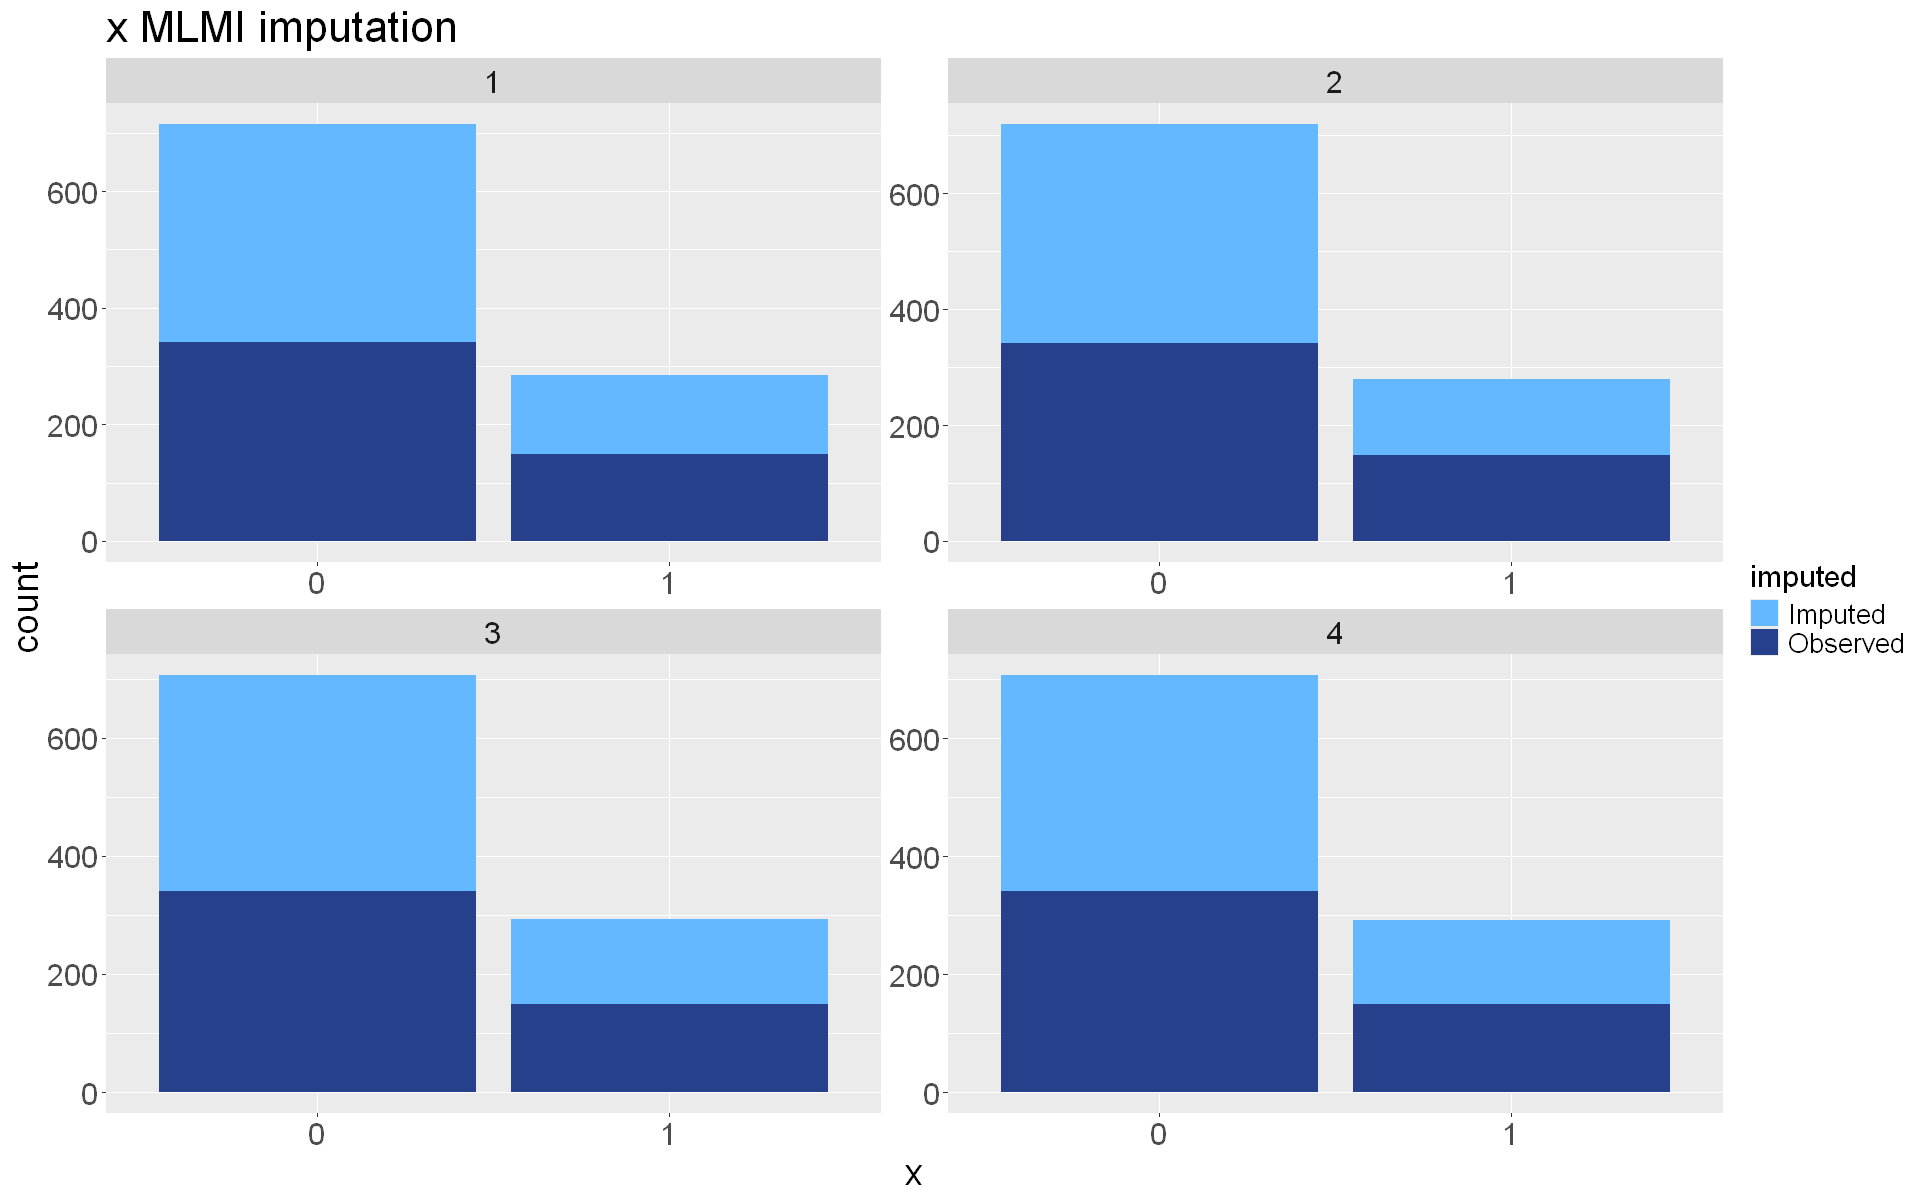

In [153]:
visImpMulCat(cat2_stack, cat2_mlmi_con, "x", "MLMI")

In [154]:
method17 <- c("ri", "", "", "")
cat3_num <- cat3
cat3_num$x <- as.numeric(as.character(cat3$x))
num3_ri <- mice(data = num3, m = 1, maxit = 1, printFlag = FALSE, method = method17, predictorMatrix = predm) %>% complete()
cat3_ri <- mice(data = cat3_num, m = 1, maxit = 1, printFlag = FALSE, method = method17, predictorMatrix = predm) %>% complete()

In [155]:
cat3_ri$x <- rescale(cat3_ri$x)
cat3_ri$x <- ifelse(cat3_ri$x > 0.5, 1, 0)
cat3_ri$x <- as.factor(cat3_ri$x)

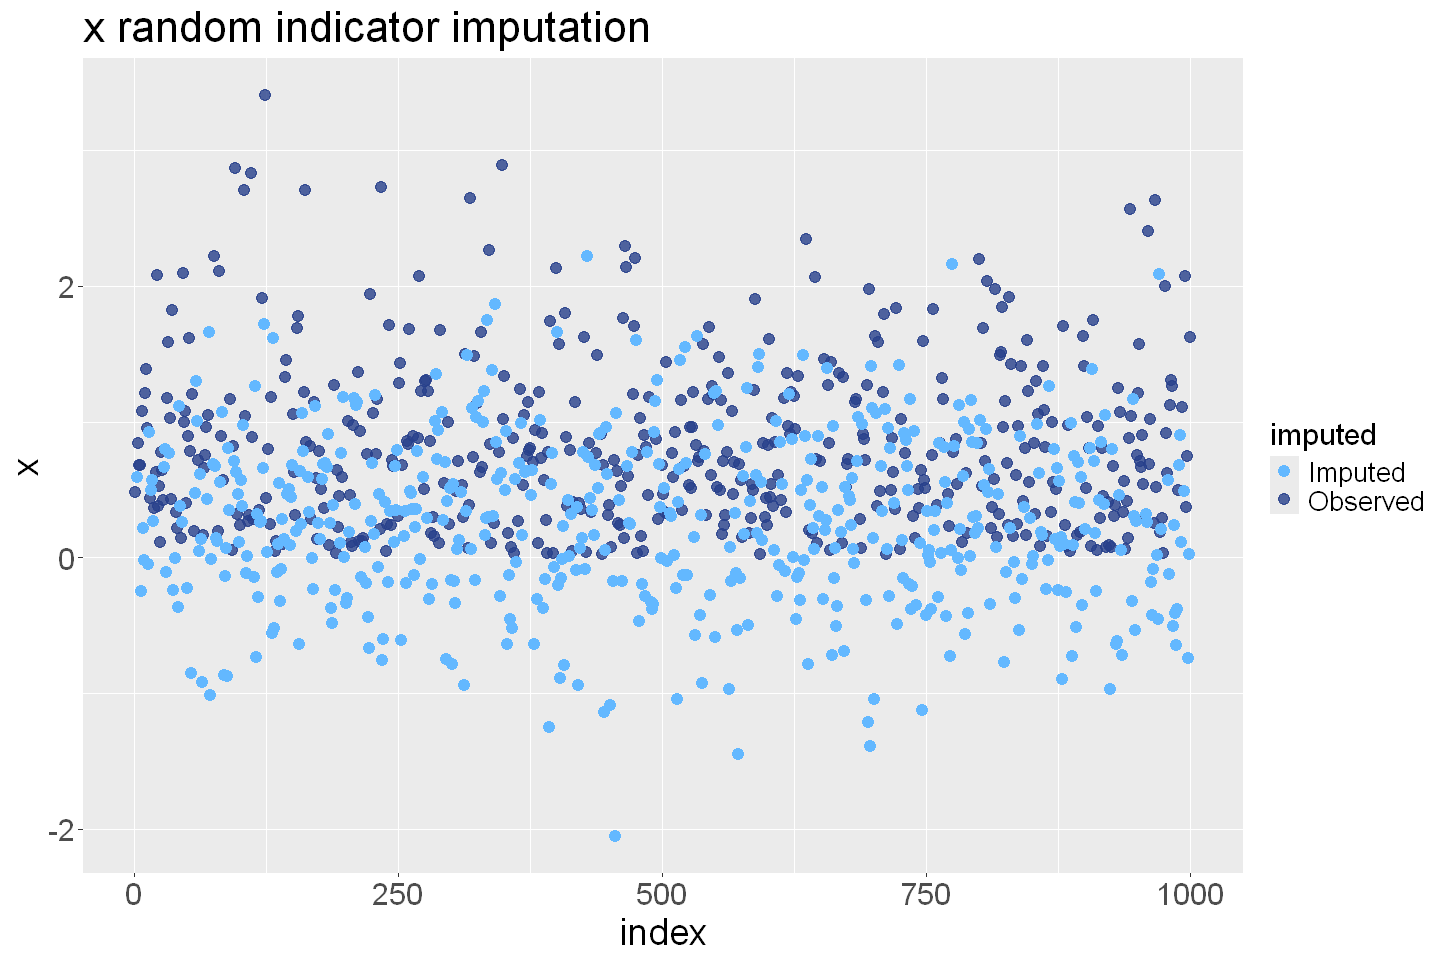

In [158]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(num3, num3_ri, "x", "random indicator")

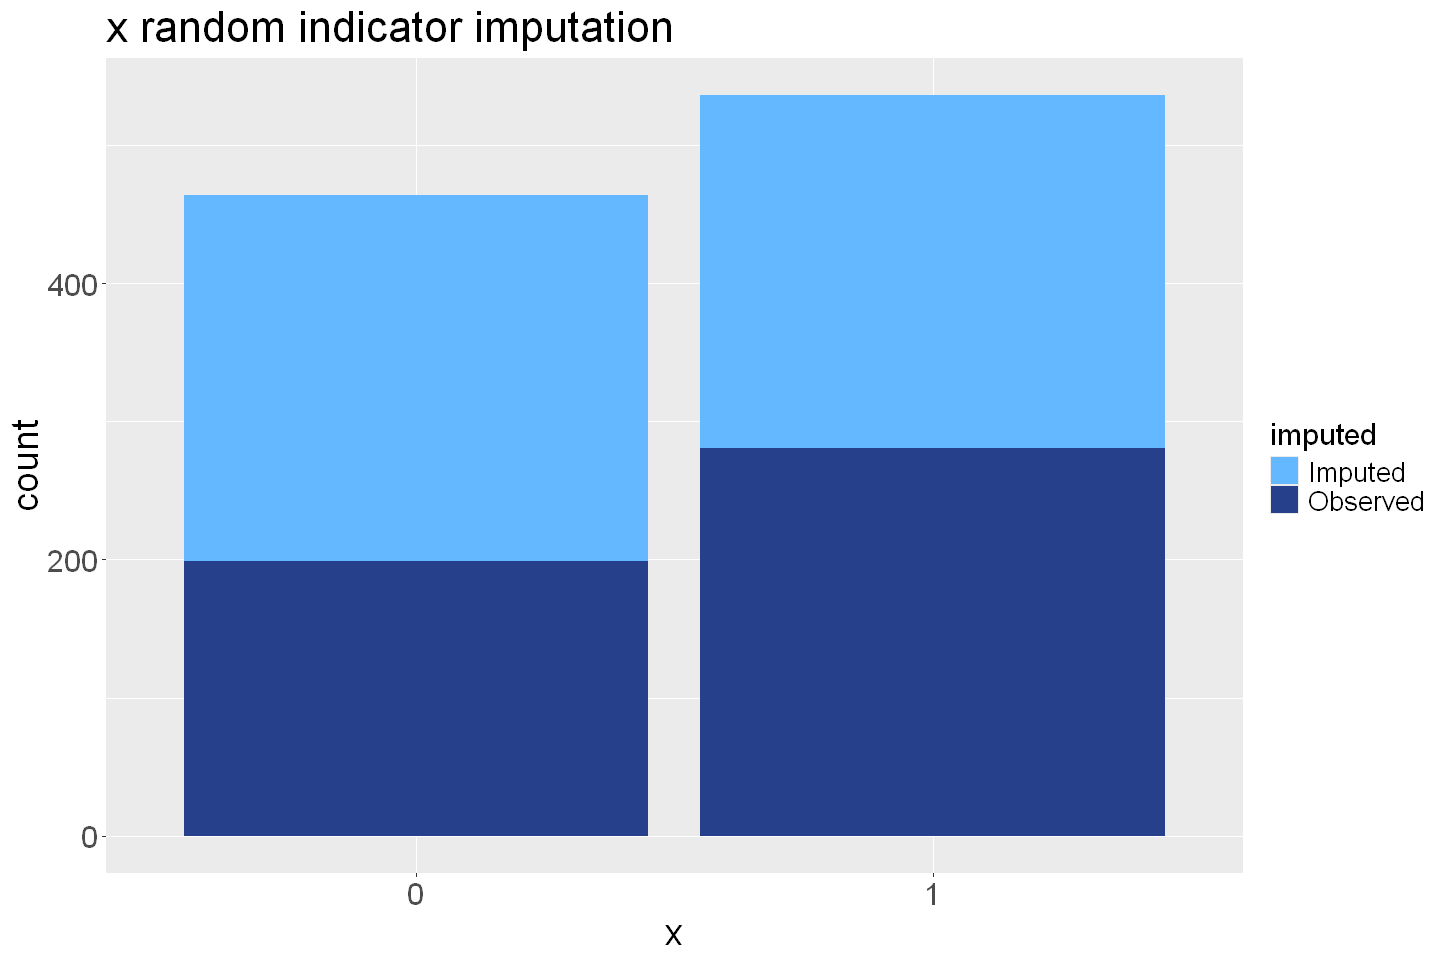

In [159]:
visImpCat(cat3_num, cat3_ri, "x", "random indicator")

In [169]:
num3$x_miss <- ifelse(is.na(num3$x), 1, 0)
predm2 <- make.predictorMatrix(num3)
predm2[,"index"] <- 0
base_blots <- list(x = list(ums = "+$"))
elicited <- c(delta_num)
l <- list(delta_num-abs(2*delta_num))
u <- list(delta_num+abs(2*delta_num))
tol <- c(abs(delta_num / 10))
parms <- rep(list(list(NA)), 1)
names(parms) <- c("x")
step <- list(abs(delta_num / 10))
MSPfamily <- "gaussian"
MSPmodels <- "x~x_miss"
m <- 4
maxit <- 10
method18 <- c("mnar.norm", "", "", "", "")
csp <- find_CSP(num3, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method18, 1234, predm2)
blots <- newblots(base_blots, list(x=csp))

[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


[1] 5


Warning message:
"Number of logged events: 40"


In [175]:
num3_narfcs <- mice(data = num3, m = 4, maxit = 10, printFlag = FALSE, method = method18, predictorMatrix = predm2, blots = blots) %>% 
complete(action="long")

Warning message:
"Number of logged events: 40"


In [176]:
num3_stack <- rbind(num3, num3, num3, num3)

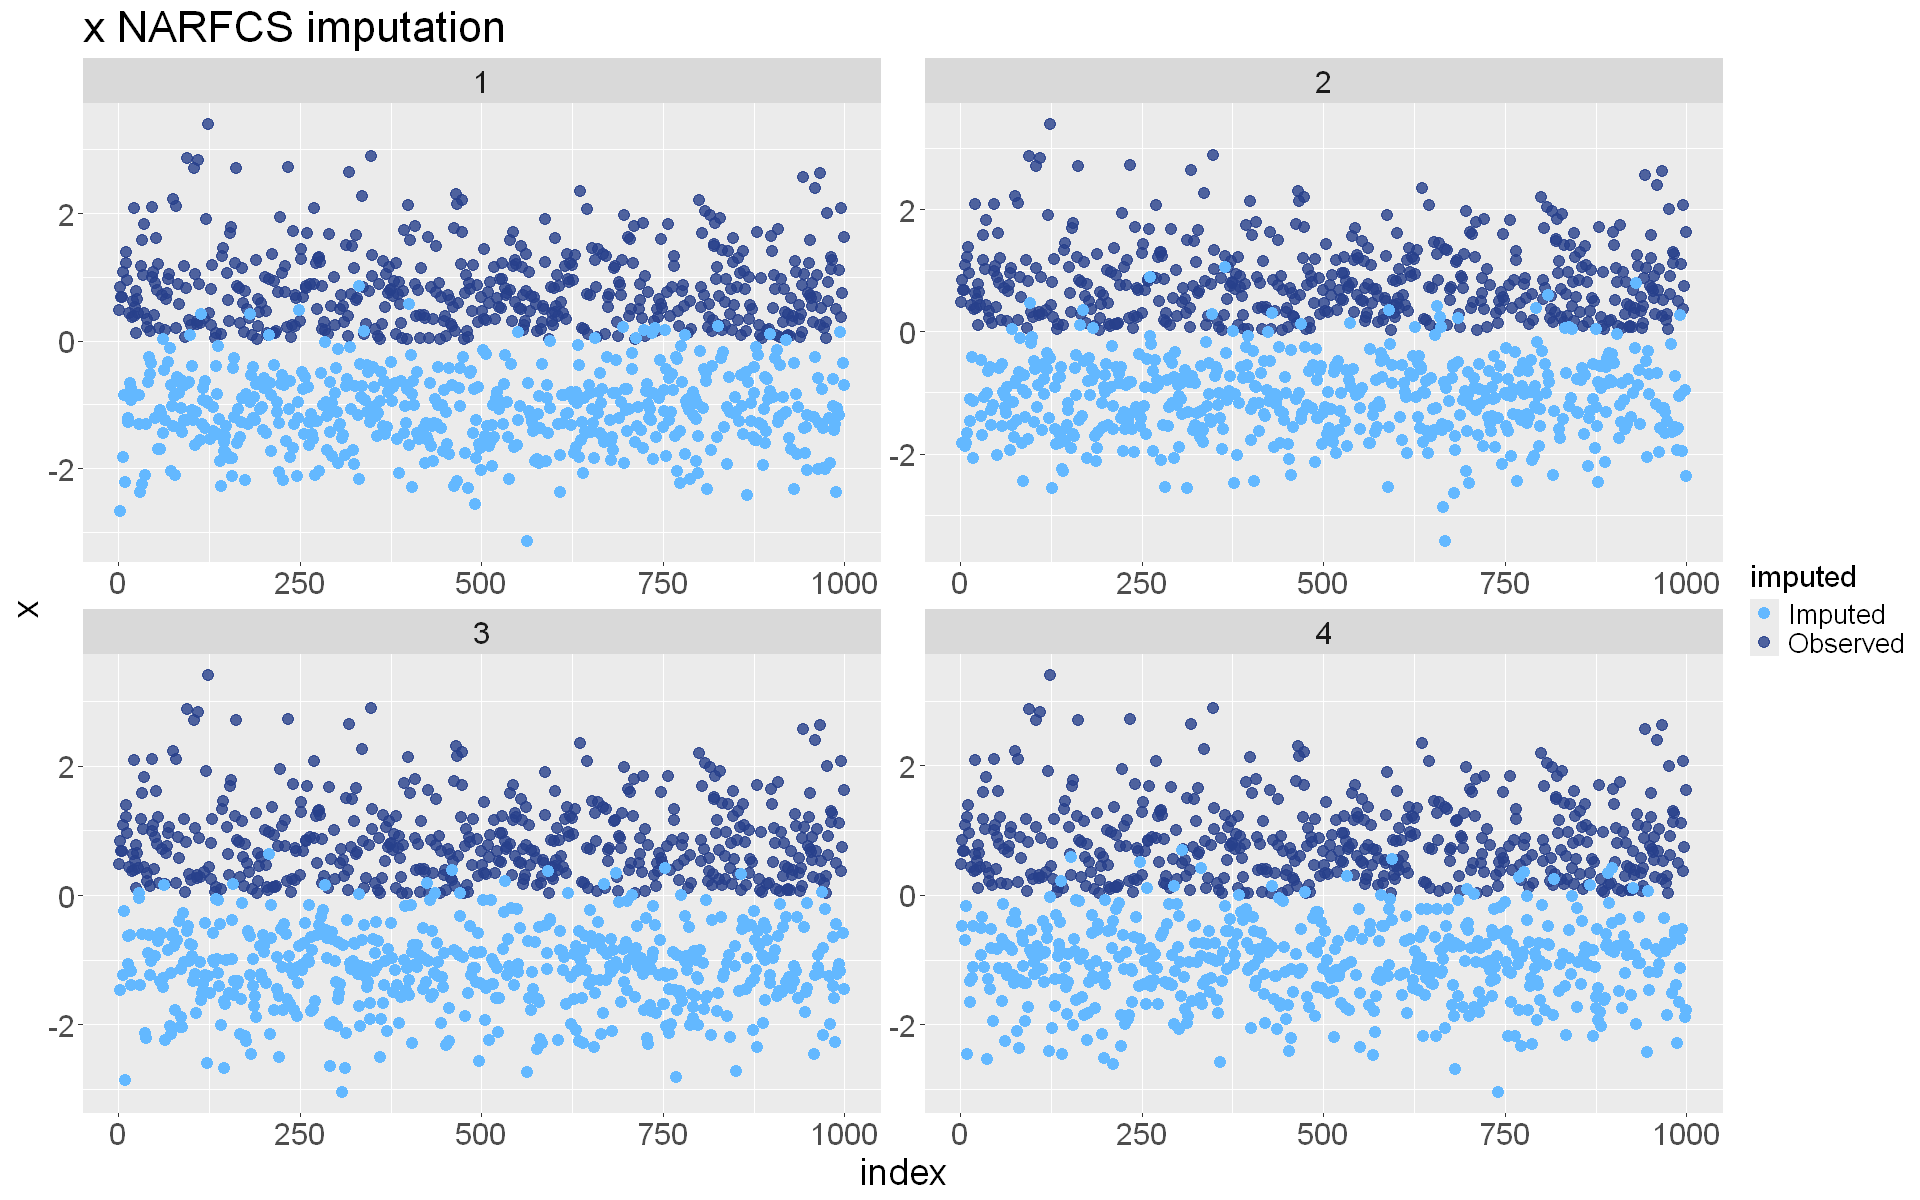

In [177]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(num3_stack, num3_narfcs, "x", "NARFCS")

In [181]:
cat3$x_miss <- ifelse(is.na(cat3$x), 1, 0)
predm2 <- make.predictorMatrix(cat3)
predm2[,"index"] <- 0
base_blots <- list(x = list(ums = "+$"))
elicited <- c(delta_cat)
l <- list(delta_cat-abs(2*delta_cat))
u <- list(delta_cat+abs(2*delta_cat))
tol <- c(abs(delta_cat / 10))
parms <- rep(list(list(NA)), 1)
names(parms) <- c("x")
step <- list(abs(delta_cat / 10))
MSPfamily <- "binomial"
MSPmodels <- "x~x_miss"
m <- 4
maxit <- 10
method19 <- c("mnar.logreg", "", "", "", "")
csp <- find_CSP(cat3, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method19, 1234, predm2)
blots <- newblots(base_blots, list(x=csp))

Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning messa

In [182]:
cat3_narfcs <- mice(data = cat3, m = 4, maxit = 10, printFlag = FALSE, method = method19, predictorMatrix = predm2, blots = blots) %>% 
complete(action="long")

Warning message:
"Number of logged events: 40"


In [183]:
cat3_stack <- rbind(cat3, cat3, cat3, cat3)

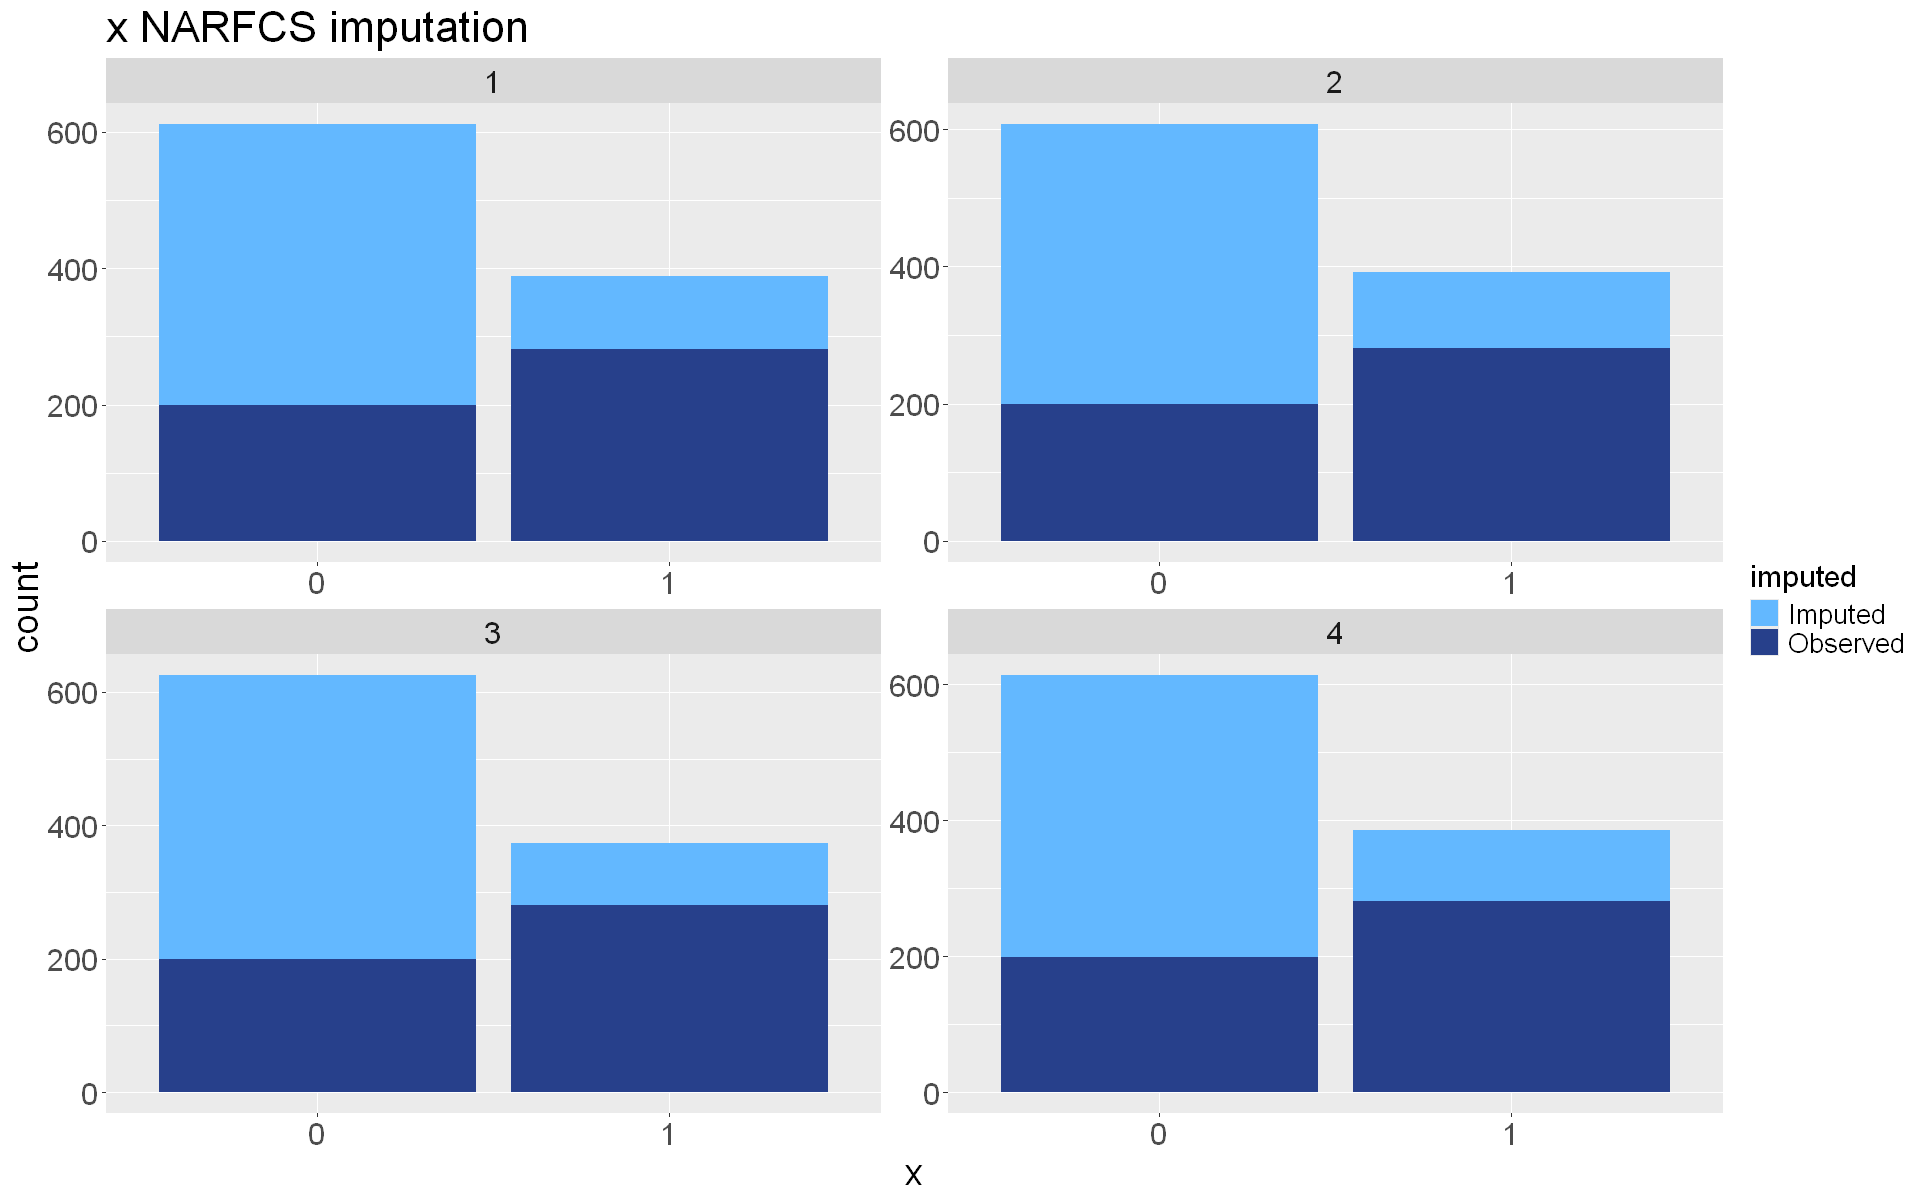

In [184]:
visImpMulCat(cat3_stack, cat3_narfcs, "x", "NARFCS")